In [145]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
import numpy as np
import matplotlib.pyplot as plt

from multiprocessing import Pool
from functools import partial

import MicroTools as micro
import MicroTools.plot_tools as pt

import MicroTools.param_scan as param_scan
from tqdm.notebook import tqdm

import MH_decay_scan_run

# 3+1 Oscillation + Decay Scans (Model II - de Gouve)

In [147]:
# Common attributes to all osc_only scans
kwargs_modelII = {
    "oscillations": True,
    "decay": True,
    "decouple_decay": True,
    "energy_degradation": True,
    "include_antineutrinos": True,
    "n_replications": 10,
    "helicity": 'conserving',
    "disappearance": True,
    "use_numu_MC": True,
    "undo_numu_normalization": False,
}

In [149]:
PERFORM_SCAN = False

In [150]:
MOCK_SCAN = False
N_MOCK = 2

n = 40 if not MOCK_SCAN else N_MOCK
# 2D scans

if PERFORM_SCAN:
    _ = MH_decay_scan_run.run_scan_gfixed_Ue4SQRfixed_2D(
        kwargs_modelII,
        f"MH_decay_gfixed_1e-3_2D_{n}_{kwargs_modelII['helicity']}_modelII",
        Npoints=n,
        Ue4SQRfixed=0.0,
        gfixed=1e-3,
        dmSq_range=(1e4, 1e9),
        Umu4Sq_range=(1e-4, 0.25),
    )

In [151]:
if PERFORM_SCAN:
    _ = MH_decay_scan_run.run_scan_gfixed_Ue4SQRfixed_2D(
    kwargs_modelII,
    f"MH_decay_gfixed_1e-3_Ue4Sq_0.1_2D_{n}_{kwargs_modelII['helicity']}_modelII",
    Npoints=n,
    Ue4SQRfixed=0.1,
    gfixed=1e-3,
    dmSq_range=(1e4, 1e9),
    Umu4Sq_range=(1e-4, 0.25),
)

In [152]:
def make_mass_vs_mixing_plot(dic, mixing='Umu4SQR', name='default', suffix='default', plot_IC=False, plot_Asimov=True, microColor='darkorange', microColor_2='grey', cmap_color='steelblue', n_sigmas=4, cmin=0.05, cmax=0.95):
    fig, ax1 = pt.std_fig(figsize=(3.2, 1.2 * 2.3617))
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel(r"$|U_{\mu 4}|^2$" if mixing =='Umu4SQR' else r"$|U_{e 4}|^2$", fontproperties=pt.font)
    ax1.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)
    ax1.set_title(name, fontsize=9)
    ax1.set_ylim(dic['dm4SQR'].min(), dic['dm4SQR'].max())
    # ax1.set_ylim(1e4, dic['dm4SQR'].max())
    ax1.set_xlim(dic[mixing].min(), dic[mixing].max())
    # ax1.set_xlim(dic[mixing].min(), 0.2)
    

    kwargs_interp = {'fine_gridx': len(np.unique(dic[mixing])),  
                    'fine_gridy': len(np.unique(dic['dm4SQR'])), 
                    'logx':True, 
                    'logy':True,
                    'method': 'interpolate',
                    }
    
    colors = pt.get_cmap_colors(cmap_color, n_sigmas, cmin=cmin, cmax=cmax)
    X, Y, Z = pt.interp_grid(dic[mixing], dic['dm4SQR'], dic['MiniApp_chi2']-np.min(dic['MiniApp_chi2']), **kwargs_interp)
    cs = ax1.contourf(X,Y,Z, levels=pt.get_chi2vals_w_nsigmas(n_sigmas, 2), colors=colors, zorder=1, alpha=1)
    cs = ax1.contour(X,Y,Z, levels=pt.get_chi2vals_w_nsigmas(n_sigmas, 2), colors=['black'], linewidths=0.25, zorder=1, alpha=1)
    # ax1.scatter(dic['Umu4SQR'], dic['dm4SQR'], c=np.log10(dic['MiniApp_chi2']-np.min(dic['MiniApp_chi2'])),)
    ax1.scatter(X.flatten()[np.nanargmin(Z)], Y.flatten()[np.nanargmin(Z)], marker='*', facecolor='white', edgecolor='black', lw=0.5, zorder=10)

    X, Y, Z = pt.interp_grid(dic[mixing], dic['dm4SQR'], dic['MicroApp_chi2']-np.min(dic['MicroApp_chi2']), **kwargs_interp)
    # cs = ax1.contourf(X,Y,Z, levels=pt.get_chi2vals_w_CL([0.95], 2)+[np.inf], edgecolors=['None'], colors=['grey'], zorder=2)
    cs = ax1.contour(X,Y,Z, levels=[pt.get_chi2vals_w_sigma(2,2),pt.get_chi2vals_w_sigma(3,2)], colors=[microColor,microColor], zorder=2, linewidths=1.5, linestyles=['-', (1,(3,0.5))])
    # cs = ax1.contour(X,Y,Z, levels=pt.get_chi2vals_w_CL([0.95], 2), colors=[microColor], zorder=2)
    ax1.plot([], [], color=microColor, lw=1.5, label='$\mu$B 2$\sigma$')
    ax1.plot([], [], color=microColor, lw=1.5, ls=(1,(3,0.5)), label='$\mu$B 3$\sigma$')

    if plot_Asimov:
        X, Y, Z = pt.interp_grid(dic[mixing], dic['dm4SQR'], dic['MicroApp_Asimov_chi2']-np.min(dic['MicroApp_Asimov_chi2']), **kwargs_interp)
        cs = ax1.contour(X,Y,Z, levels=[pt.get_chi2vals_w_sigma(3,2)], colors=[microColor_2], linestyles=[(1,(3,0.5))], linewidths=1.5, zorder=2)
        ax1.plot([], [], color=microColor_2, lw=1.5, ls=(1,(3,0.5)), label='$\mu$B $3\sigma$ (Asimov)')
    
    # ------ get the legend-entries that are already attached to the axis
    # ------ get the legend-entries that are already attached to the axis
    h, l = ax1.get_legend_handles_labels()
    mb_label = 'MB '+', '.join([fr'${i+1} \sigma$' for i in range(n_sigmas)])
    leg1 = ax1.legend([pt.MulticolorPatch(colors)], [mb_label], loc='upper right', fontsize=9, handler_map={pt.MulticolorPatch: pt.MulticolorPatchHandler()}, facecolor='white', edgecolor='None', frameon=True, framealpha=0.8)
    leg2 = ax1.legend(h, l, loc=(0.025,0), fontsize=9, handler_map={pt.MulticolorPatch: pt.MulticolorPatchHandler()}, facecolor='white', edgecolor='None', frameon=True, framealpha=0.7)
    ax1.add_artist(leg1)
    # ax1.add_artist(leg2)

    if plot_IC:
        x, y = np.genfromtxt('MicroTools/osc_data/IceCube_2022_sterile_decay_90CL.dat', unpack=True)
        x,y = pt.get_ordered_closed_region([x,y], logx=True, logy=True)
        ax1.fill(x, y, facecolor='orange', edgecolor='darkorange', lw=0.5, ls='-', alpha=0.25, hatch='')
        ax1.annotate('IC 90\% CL', xy=(0.038, 2.8), xycoords='data', rotation=12, color='darkorange', fontsize=9)
        ax1.annotate('IC 99\% CL', xy=(0.048, 0.5), xycoords='data', rotation=18, color='darkorange', fontsize=9)
        x, y = np.genfromtxt('MicroTools/osc_data/IceCube_2022_sterile_decay_99CL.dat', unpack=True)
        ax1.plot(x, y, color='darkorange', lw=1, ls='-', alpha=1,zorder=4)

    fig.savefig(f"{micro.path_plots}/MH_decay_{mixing}_profiled_{suffix}.pdf", bbox_inches='tight', dpi=350)

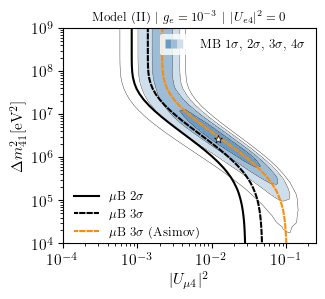

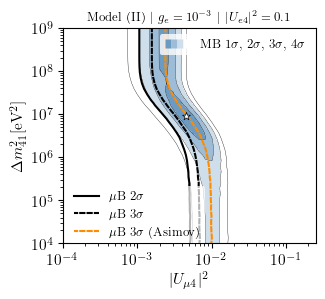

In [68]:
CMAP = 'steelblue'
microColor='black'
microColor_2 = 'darkorange'

kwargs = {'plot_IC': False, 'plot_Asimov': True, 'microColor': microColor, 'microColor_2': microColor_2, 'cmap_color': CMAP, 'n_sigmas': 4, 'cmin': 0.2, 'cmax': 1}

dic_dec_gfixed_0p001 = param_scan.load_scan_data('fit_data/MH_decay_gfixed_1e-3_2D_40_conserving_modelII.pkl')
make_mass_vs_mixing_plot(dic_dec_gfixed_0p001, mixing='Umu4SQR', name=r'Model (II) $\vert$ $g_e=10^{-3}$ $\vert$ $|U_{e4}|^2 = 0$', suffix='gfixed_1e-3', **kwargs)
dic_dec_gfixed_0p001_BEST = param_scan.load_scan_data('fit_data/MH_decay_gfixed_1e-3_Ue4Sq_0.1_2D_40_conserving_modelII.pkl')
make_mass_vs_mixing_plot(dic_dec_gfixed_0p001_BEST, mixing='Umu4SQR', name=r'Model (II) $\vert$ $g_e=10^{-3}$ $\vert$ $|U_{e4}|^2 = 0.1$', suffix='gfixed_1e-3_BEST', **kwargs)

In [153]:
bf_1 = param_scan.get_best_fit_point(dic_dec_gfixed_0p001)
bf_2 = param_scan.get_best_fit_point(dic_dec_gfixed_0p001_BEST)

print(bf_1, param_scan.get_best_fit_point_MBpval(dic_dec_gfixed_0p001, ndof=20+2*8-1), param_scan.get_best_fit_point_DeltaMicroChi2(dic_dec_gfixed_0p001))
print(bf_2, param_scan.get_best_fit_point_MBpval(dic_dec_gfixed_0p001_BEST, ndof=20+2*8-1), param_scan.get_best_fit_point_DeltaMicroChi2(dic_dec_gfixed_0p001_BEST))

{'g': 0.001, 'm4': 1651.7667439704583, 'Ue4Sq': 0.0, 'Um4Sq': 0.01233218426765458, 'sin2theta': 0.0, 'dm4SQR': 2728333.3764867694, 'MiniApp_chi2': 34.45903929112757, 'MicroApp_chi2': 112.98435471543603, 'MicroApp_Asimov_chi2': 13.29793628513788, 'MiniApp_deltachi2': 0.0, 'MicroApp_deltachi2': 20.21930665211252, 'MicroApp_Asimov_deltachi2': 10.48282677907684} 0.49405691292022424 20.21930665211252
{'g': 0.001, 'm4': 2980.9793965647277, 'Ue4Sq': 0.1, 'Um4Sq': 0.004522792578836114, 'sin2theta': 0.001809, 'dm4SQR': 8886238.162743408, 'MiniApp_chi2': 38.6099708155941, 'MicroApp_chi2': 112.53939243740741, 'MicroApp_Asimov_chi2': 14.211420494334707, 'MiniApp_deltachi2': 0.0, 'MicroApp_deltachi2': 20.880190138939525, 'MicroApp_Asimov_deltachi2': 10.310077678336743} 0.3097350230475078 20.880190138939525


# 3+1 Oscillation + Decay Scans

In [70]:
# Common attributes to all osc_only scans
kwargs_modelI = {
    "oscillations": True,
    "decay": True,
    "decouple_decay": False,
    "energy_degradation": True,
    "include_antineutrinos": True,
    "n_replications": 10,
    "helicity": 'conserving',
    "disappearance": True,
    "use_numu_MC": True,
    "undo_numu_normalization": False,
}


In [71]:
n = 30 if not MOCK_SCAN else N_MOCK
if PERFORM_SCAN:
    # 2D scans
    _ = MH_decay_scan_run.run_scan_gfixed_Ue4SQRfixed_2D(
        kwargs_modelI,
        f"MH_decay_gfixed_2.5_Ue4SQRfixed_0.05_2D_{n}_{kwargs_modelI['helicity']}_modelI",
        Npoints=n,
        Ue4SQRfixed=0.05,
        gfixed=2.5,
    )

    # 2D scans
    _ = MH_decay_scan_run.run_scan_gfixed_Ue4SQRfixed_2D(
        kwargs_modelI,
        f"MH_decay_gfixed_2.5_Ue4SQRfixed_0.10_2D_{n}_{kwargs_modelI['helicity']}_modelI",
        Npoints=n,
        Ue4SQRfixed=0.1,
        gfixed=2.5,
    )

    # 2D scans
    _ = MH_decay_scan_run.run_scan_gfixed_Ue4SQRfixed_2D(
        kwargs_modelI,
        f"MH_decay_gfixed_1.0_Ue4SQRfixed_0.05_2D_{n}_{kwargs_modelI['helicity']}_modelI",
        Npoints=n,
        Ue4SQRfixed=0.05,
        gfixed=1,
    )

    # 2D scans
    _ = MH_decay_scan_run.run_scan_gfixed_Ue4SQRfixed_2D(
        kwargs_modelI,
        f"MH_decay_gfixed_1.0_Ue4SQRfixed_0.10_2D_{n}_{kwargs_modelI['helicity']}_modelI",
        Npoints=n,
        Ue4SQRfixed=0.1,
        gfixed=1,
    )

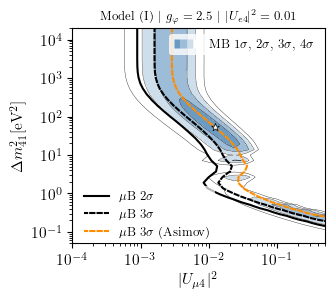

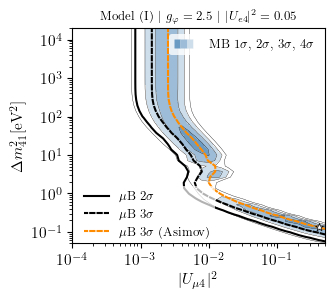

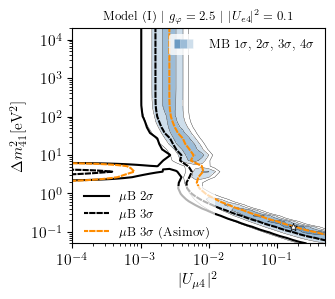

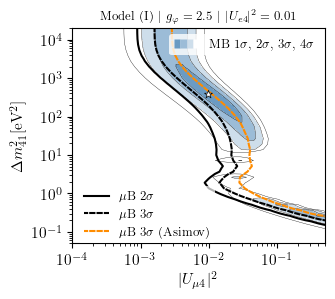

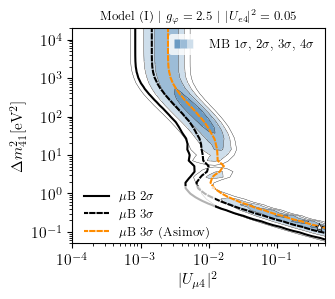

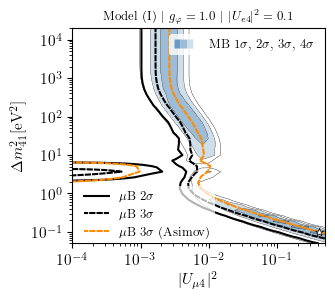

In [14]:
CMAP = 'steelblue'
microColor='black'
microColor_2 = 'darkorange'

kwargs = {'plot_IC': False, 'plot_Asimov': True, 'microColor': microColor, 'microColor_2': microColor_2, 'cmap_color': CMAP, 'n_sigmas': 4, 'cmin': 0.2, 'cmax': 1}

# dic_dec_gfixed_2p5_solar = param_scan.load_scan_data('fit_data/MH_decay_gfixed_2.5_Ue4SQRfixed_0.05_2D_30_conserving_modelI.pkl')
dic_dec_gfixed_2p5_small = param_scan.load_scan_data('fit_data/MH_decay_gfixed_2.5_Ue4SQRfixed_0.01_2D_40.pkl')
make_mass_vs_mixing_plot(dic_dec_gfixed_2p5_small, mixing='Umu4SQR', name=r'Model (I) $\vert$ $g_\varphi=2.5$ $\vert$ $|U_{e4}|^2 = 0.01$', suffix='gfixed_2.5_small', **kwargs)
# dic_dec_gfixed_2p5_solar = param_scan.load_scan_data('fit_data/MH_decay_gfixed_2.5_Ue4SQRfixed_0.05_2D_30_conserving_modelI.pkl')
dic_dec_gfixed_2p5_solar = param_scan.load_scan_data('fit_data/MH_decay_gfixed_2.5_Ue4SQRfixed_0.05_2D_40.pkl')
make_mass_vs_mixing_plot(dic_dec_gfixed_2p5_solar, mixing='Umu4SQR', name=r'Model (I) $\vert$ $g_\varphi=2.5$ $\vert$ $|U_{e4}|^2 = 0.05$', suffix='gfixed_2.5_solar', **kwargs)
# dic_dec_gfixed_2p5_BEST = param_scan.load_scan_data('fit_data/MH_decay_gfixed_2.5_Ue4SQRfixed_0.10_2D_30_conserving_modelI.pkl')
dic_dec_gfixed_2p5_BEST = param_scan.load_scan_data('fit_data/MH_decay_gfixed_2.5_Ue4SQRfixed_0.10_2D_40.pkl')
make_mass_vs_mixing_plot(dic_dec_gfixed_2p5_BEST, mixing='Umu4SQR', name=r'Model (I) $\vert$ $g_\varphi=2.5$ $\vert$ $|U_{e4}|^2 = 0.1$', suffix='gfixed_2.5_BEST', **kwargs)


dic_dec_gfixed_1p0_small = param_scan.load_scan_data('fit_data/MH_decay_gfixed_1_Ue4SQRfixed_0.01_2D_40.pkl')
make_mass_vs_mixing_plot(dic_dec_gfixed_1p0_small, mixing='Umu4SQR', name=r'Model (I) $\vert$ $g_\varphi=2.5$ $\vert$ $|U_{e4}|^2 = 0.01$', suffix='gfixed_1.0_small', **kwargs)
# dic_dec_gfixed_1p0_solar = param_scan.load_scan_data('fit_data/MH_decay_gfixed_1.0_Ue4SQRfixed_0.05_2D_30_conserving_modelI.pkl')
dic_dec_gfixed_1p0_solar = param_scan.load_scan_data('fit_data/MH_decay_gfixed_1_Ue4SQRfixed_0.05_2D_40.pkl')
make_mass_vs_mixing_plot(dic_dec_gfixed_1p0_solar, mixing='Umu4SQR', name=r'Model (I) $\vert$ $g_\varphi=2.5$ $\vert$ $|U_{e4}|^2 = 0.05$', suffix='gfixed_1.0_solar', **kwargs)
# dic_dec_gfixed_1p0_BEST = param_scan.load_scan_data('fit_data/MH_decay_gfixed_1.0_Ue4SQRfixed_0.10_2D_30_conserving_modelI.pkl')
dic_dec_gfixed_1p0_BEST = param_scan.load_scan_data('fit_data/MH_decay_gfixed_1_Ue4SQRfixed_0.10_2D_40.pkl')
make_mass_vs_mixing_plot(dic_dec_gfixed_1p0_BEST, mixing='Umu4SQR', name=r'Model (I) $\vert$ $g_\varphi=1.0$ $\vert$ $|U_{e4}|^2 = 0.1$', suffix='gfixed_1.0_BEST', **kwargs)

In [15]:
print(param_scan.get_best_fit_point(dic_dec_gfixed_2p5_small), param_scan.get_best_fit_point_MBpval(dic_dec_gfixed_2p5_small, ndof=20+2*8-1), param_scan.get_best_fit_point_DeltaMicroChi2(dic_dec_gfixed_2p5_small))
print(param_scan.get_best_fit_point(dic_dec_gfixed_2p5_solar), param_scan.get_best_fit_point_MBpval(dic_dec_gfixed_2p5_solar, ndof=20+2*8-1), param_scan.get_best_fit_point_DeltaMicroChi2(dic_dec_gfixed_2p5_solar))
print(param_scan.get_best_fit_point(dic_dec_gfixed_2p5_BEST), param_scan.get_best_fit_point_MBpval(dic_dec_gfixed_2p5_BEST, ndof=20+2*8-1), param_scan.get_best_fit_point_DeltaMicroChi2(dic_dec_gfixed_2p5_BEST))

print(param_scan.get_best_fit_point(dic_dec_gfixed_1p0_small), param_scan.get_best_fit_point_MBpval(dic_dec_gfixed_1p0_small, ndof=20+2*8-1), param_scan.get_best_fit_point_DeltaMicroChi2(dic_dec_gfixed_1p0_small))
print(param_scan.get_best_fit_point(dic_dec_gfixed_1p0_solar), param_scan.get_best_fit_point_MBpval(dic_dec_gfixed_1p0_solar, ndof=20+2*8-1), param_scan.get_best_fit_point_DeltaMicroChi2(dic_dec_gfixed_1p0_solar))
print(param_scan.get_best_fit_point(dic_dec_gfixed_1p0_BEST), param_scan.get_best_fit_point_MBpval(dic_dec_gfixed_1p0_BEST, ndof=20+2*8-1), param_scan.get_best_fit_point_DeltaMicroChi2(dic_dec_gfixed_1p0_BEST))


{'g': 2.5, 'm4': 7.206624982959387, 'Ue4Sq': 0.01, 'Um4Sq': 0.012206705418775088, 'sin2theta': 0.000488, 'dm4SQR': 51.93544364501439, 'MiniApp_chi2': 36.186484176957904, 'MicroApp_chi2': 114.73750121395923, 'MicroApp_Asimov_chi2': 14.404660585502768, 'MiniApp_deltachi2': 0.0, 'MicroApp_deltachi2': 22.794717374122627, 'MicroApp_Asimov_deltachi2': 11.595275371640458} 0.4130104716274652 22.794717374122627
{'g': 2.5, 'm4': 0.3672390438532148, 'Ue4Sq': 0.05, 'Um4Sq': 0.401906120162261, 'sin2theta': 0.080381, 'dm4SQR': 0.13486451533022345, 'MiniApp_chi2': 36.13348171939802, 'MicroApp_chi2': 114.41217664733502, 'MicroApp_Asimov_chi2': 14.973355889432579, 'MiniApp_deltachi2': 0.0, 'MicroApp_deltachi2': 24.287355141650806, 'MicroApp_Asimov_deltachi2': 12.163780689651217} 0.4154222889845253 24.287355141650806
{'g': 2.5, 'm4': 0.3672390438532148, 'Ue4Sq': 0.1, 'Um4Sq': 0.16778111673912144, 'sin2theta': 0.067112, 'dm4SQR': 0.13486451533022345, 'MiniApp_chi2': 35.80129986082234, 'MicroApp_chi2': 11

# 3D and 4D plots

In [154]:
def profile_for_sin2theta(data_dic):
    dic_prof = {}
    # Profile each chi2
    dic_prof['sin2theta'], dic_prof['dm4SQR'], dic_prof['MiniApp_chi2'] = param_scan.profile_in_plane(data_dic['sin2theta'], data_dic['dm4SQR'], data_dic['MiniApp_chi2'])
    dic_prof['sin2theta'], dic_prof['dm4SQR'], dic_prof['MicroApp_chi2'] = param_scan.profile_in_plane(data_dic['sin2theta'], data_dic['dm4SQR'], data_dic['MicroApp_chi2'])
    dic_prof['sin2theta'], dic_prof['dm4SQR'], dic_prof['MicroApp_Asimov_chi2'] = param_scan.profile_in_plane(data_dic['sin2theta'], data_dic['dm4SQR'], data_dic['MicroApp_Asimov_chi2'])
    return dic_prof

def profile_x_y(data_dic, xlabel, ylabel):
    dic_prof = {}
    # Profile each chi2
    dic_prof[xlabel], dic_prof[ylabel], dic_prof['MiniApp_chi2'] = param_scan.profile_in_plane(data_dic[xlabel], data_dic[ylabel], data_dic['MiniApp_chi2'])
    dic_prof[xlabel], dic_prof[ylabel], dic_prof['MicroApp_chi2'] = param_scan.profile_in_plane(data_dic[xlabel], data_dic[ylabel], data_dic['MicroApp_chi2'])
    dic_prof[xlabel], dic_prof[ylabel], dic_prof['MicroApp_Asimov_chi2'] = param_scan.profile_in_plane(data_dic[xlabel], data_dic[ylabel], data_dic['MicroApp_Asimov_chi2'])
    return dic_prof


In [155]:
dic_full_prof = profile_x_y(param_scan.load_scan_data('fit_data/MH_decay_4D_30.pkl'), xlabel='sin2theta', ylabel='dm4SQR')
dic_g_one_prof = profile_x_y(param_scan.load_scan_data('fit_data/MH_decay_4D_30.pkl', wi=0, w_fixed=1), xlabel='sin2theta', ylabel='dm4SQR')
dic_g_twofive_prof = profile_x_y(param_scan.load_scan_data('fit_data/MH_decay_4D_30.pkl', wi=0, w_fixed=2.5), xlabel='sin2theta', ylabel='dm4SQR')

dic_Ue4sqr_solar_prof = profile_x_y(param_scan.load_scan_data('fit_data/MH_decay_4D_30.pkl', wi=2, w_fixed=0.05), xlabel='sin2theta', ylabel='dm4SQR')
dic_Ue4sqr_BEST_prof = profile_x_y(param_scan.load_scan_data('fit_data/MH_decay_4D_30.pkl', wi=2, w_fixed=0.1), xlabel='sin2theta', ylabel='dm4SQR')


data_full_gfixed_2p5_Umu4prof = profile_x_y(param_scan.load_scan_data('fit_data/MH_decay_gfixed_2.5_3D_40.pkl'), xlabel='Umu4SQR', ylabel='dm4SQR')
data_full_gfixed_2p5_Ue4prof = profile_x_y(param_scan.load_scan_data('fit_data/MH_decay_gfixed_2.5_3D_40.pkl'), xlabel='Ue4SQR', ylabel='dm4SQR')

data_full_gfixed_2p5_solar_Umu4prof = profile_x_y(param_scan.load_scan_data('fit_data/MH_decay_gfixed_2.5_3D_40.pkl', wi=2, w_fixed=0.05), xlabel='Umu4SQR', ylabel='dm4SQR')
data_full_gfixed_2p5_best_Umu4prof = profile_x_y(param_scan.load_scan_data('fit_data/MH_decay_gfixed_2.5_3D_40.pkl', wi=2, w_fixed=0.1), xlabel='Umu4SQR', ylabel='dm4SQR')

data_full_gfixed_2p5_small_Ue4prof = profile_x_y(param_scan.load_scan_data('fit_data/MH_decay_gfixed_2.5_3D_40.pkl', wi=3, w_fixed=0.01), xlabel='Ue4SQR', ylabel='dm4SQR')
data_full_gfixed_2p5_solar_Ue4prof = profile_x_y(param_scan.load_scan_data('fit_data/MH_decay_gfixed_2.5_3D_40.pkl', wi=3, w_fixed=0.05), xlabel='Ue4SQR', ylabel='dm4SQR')
data_full_gfixed_2p5_best_Ue4prof = profile_x_y(param_scan.load_scan_data('fit_data/MH_decay_gfixed_2.5_3D_40.pkl', wi=3, w_fixed=0.1), xlabel='Ue4SQR', ylabel='dm4SQR')


data_full_gfixed_1p0_Umu4prof = profile_x_y(param_scan.load_scan_data('fit_data/MH_decay_gfixed_1.0_3D_40.pkl'), xlabel='Umu4SQR', ylabel='dm4SQR')
data_full_gfixed_1p0_Ue4prof = profile_x_y(param_scan.load_scan_data('fit_data/MH_decay_gfixed_1.0_3D_40.pkl'), xlabel='Ue4SQR', ylabel='dm4SQR')

data_full_gfixed_1p0_solar_Umu4prof = profile_x_y(param_scan.load_scan_data('fit_data/MH_decay_gfixed_1.0_3D_40.pkl', wi=2, w_fixed=0.05), xlabel='Umu4SQR', ylabel='dm4SQR')
data_full_gfixed_1p0_best_Umu4prof = profile_x_y(param_scan.load_scan_data('fit_data/MH_decay_gfixed_1.0_3D_40.pkl', wi=2, w_fixed=0.1), xlabel='Umu4SQR', ylabel='dm4SQR')

data_full_gfixed_1p0_small_Ue4prof = profile_x_y(param_scan.load_scan_data('fit_data/MH_decay_gfixed_1.0_3D_40.pkl', wi=3, w_fixed=0.01), xlabel='Ue4SQR', ylabel='dm4SQR')
data_full_gfixed_1p0_solar_Ue4prof = profile_x_y(param_scan.load_scan_data('fit_data/MH_decay_gfixed_1.0_3D_40.pkl', wi=3, w_fixed=0.05), xlabel='Ue4SQR', ylabel='dm4SQR')
data_full_gfixed_1p0_best_Ue4prof = profile_x_y(param_scan.load_scan_data('fit_data/MH_decay_gfixed_1.0_3D_40.pkl', wi=3, w_fixed=0.1), xlabel='Ue4SQR', ylabel='dm4SQR')

In [156]:
data_full_gfixed_2p5_dmfixed_100 = profile_x_y(param_scan.load_scan_data('fit_data/MH_decay_4D_30.pkl', wi=1, w_fixed=100, w2i=0, w2_fixed=2.5, ), xlabel='Ue4SQR', ylabel='Umu4SQR')
data_full_gfixed_1p0_dmfixed_100 = profile_x_y(param_scan.load_scan_data('fit_data/MH_decay_4D_30.pkl', wi=1, w_fixed=100, w2i=0, w2_fixed=1.0, ), xlabel='Ue4SQR', ylabel='Umu4SQR')

data_full_gfixed_2p5_dmfixed_500 = profile_x_y(param_scan.load_scan_data('fit_data/MH_decay_4D_30.pkl', wi=1, w_fixed=500, w2i=0, w2_fixed=2.5, ), xlabel='Ue4SQR', ylabel='Umu4SQR')
data_full_gfixed_1p0_dmfixed_500 = profile_x_y(param_scan.load_scan_data('fit_data/MH_decay_4D_30.pkl', wi=1, w_fixed=500, w2i=0, w2_fixed=1.0, ), xlabel='Ue4SQR', ylabel='Umu4SQR')

# Inspect the best fit in each case

In [157]:
dic_osc_app = param_scan.load_scan_data('fit_data/MH_apponly_50.pkl')
dic_osc_full = param_scan.load_scan_data('fit_data/MH_fullosc_3D_50.pkl')
dic_dec_full = param_scan.load_scan_data('fit_data/MH_decay_4D_30.pkl')
dic_dec_gfixed_2p5 = param_scan.load_scan_data('fit_data/MH_decay_gfixed_2.5_3D_40.pkl')
dic_dec_gfixed_1p0 = param_scan.load_scan_data('fit_data/MH_decay_gfixed_1.0_3D_40.pkl')

bf_osc_app = param_scan.get_best_fit_point(dic_osc_app)
bf_osc_full = param_scan.get_best_fit_point(dic_osc_full)
bf_dec_full = param_scan.get_best_fit_point(dic_dec_full)
bf_dec_gfixed_2p5 = param_scan.get_best_fit_point(dic_dec_gfixed_2p5)
bf_dec_gfixed_1p0 = param_scan.get_best_fit_point(dic_dec_gfixed_1p0)

In [158]:
NDOF = 17.3+4
print(param_scan.get_null_point_definition(dic_osc_app, ndof=20))
print(param_scan.get_null_point_definition(dic_osc_full, ndof=NDOF))
print(param_scan.get_null_point_definition(dic_dec_full, ndof = NDOF-4))
print(param_scan.get_null_point_definition(dic_dec_gfixed_2p5, ndof = NDOF-3))
print(param_scan.get_null_point_definition(dic_dec_gfixed_1p0, ndof = NDOF-3))

g = 1e-10
dm4SQR = 0.01 eV^2
Ue4SQR = 5e-05
Umu4SQR = 0.5
MB chi2 = 69
MB pval = 2.4e-05%
Micro deltachi2 = 0
g = 1
dm4SQR = 0.1 eV^2
Ue4SQR = 0.001
Umu4SQR = 0.0001
MB chi2 = 69
MB pval = 5.9e-05%
Micro deltachi2 = 2.9
g = 0.01
dm4SQR = 0.1 eV^2
Ue4SQR = 0.0001
Umu4SQR = 0.0001
MB chi2 = 69
MB pval = 3.9e-06%
Micro deltachi2 = 2.8
g = 2.5
dm4SQR = 0.1 eV^2
Ue4SQR = 0.001
Umu4SQR = 0.0001
MB chi2 = 69
MB pval = 8e-06%
Micro deltachi2 = 2.9
g = 1
dm4SQR = 0.1 eV^2
Ue4SQR = 0.001
Umu4SQR = 0.0001
MB chi2 = 69
MB pval = 8e-06%
Micro deltachi2 = 2.9


In [159]:
NDOF = 17.3+4
print(param_scan.get_bf_point_definition(dic_osc_app, ndof=NDOF-2))
print(param_scan.get_bf_point_definition(dic_osc_full, ndof=NDOF-3))
print(param_scan.get_bf_point_definition(dic_dec_full, ndof = NDOF-4))
print(param_scan.get_bf_point_definition(dic_dec_gfixed_2p5, ndof = NDOF-3))
print(param_scan.get_bf_point_definition(dic_dec_gfixed_1p0, ndof = NDOF-3))

g = 1e-10
dm4SQR = 0.066 eV^2
Ue4SQR = 0.21
Umu4SQR = 0.5
MB chi2 = 37
MB pval = 1%
Micro deltachi2 = 21
g = 1
dm4SQR = 0.18 eV^2
Ue4SQR = 0.031
Umu4SQR = 0.42
MB chi2 = 36
MB pval = 0.73%
Micro deltachi2 = 21
g = 3.04
dm4SQR = 0.1 eV^2
Ue4SQR = 0.21
Umu4SQR = 0.15
MB chi2 = 35
MB pval = 0.64%
Micro deltachi2 = 22
g = 2.5
dm4SQR = 0.1 eV^2
Ue4SQR = 0.19
Umu4SQR = 0.17
MB chi2 = 36
MB pval = 0.9%
Micro deltachi2 = 20
g = 1
dm4SQR = 2.4e+02 eV^2
Ue4SQR = 0.013
Umu4SQR = 0.012
MB chi2 = 36
MB pval = 0.8%
Micro deltachi2 = 23


### Mixing vs dm4 (fixed other)

In [160]:
def make_mass_vs_mixing_plot(dic, mixing='Umu4SQR', name='default', suffix='default', plot_IC=False, plot_Asimov=True, cmap_color='steelblue', n_sigmas=4, cmin=0.05, cmax=0.95):
    fig, ax1 = pt.std_fig(figsize=(3.2, 1.5 * 2.3617))
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel(r"$|U_{\mu 4}|^2$" if mixing =='Umu4SQR' else r"$|U_{e 4}|^2$", fontproperties=pt.font)
    ax1.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)
    ax1.set_title(name, fontsize=10)
    ax1.set_ylim(dic['dm4SQR'].min(), dic['dm4SQR'].max())
    ax1.set_xlim(dic[mixing].min(), dic[mixing].max())
    

    kwargs_interp = {'fine_gridx': len(np.unique(dic[mixing])),  
                    'fine_gridy': len(np.unique(dic['dm4SQR'])), 
                    'logx':True, 
                    'logy':True,
                    'method': 'interpolate',
                    }
    
    colors = pt.get_cmap_colors(cmap_color, n_sigmas, cmin=cmin, cmax=cmax)
    X, Y, Z = pt.interp_grid(dic[mixing], dic['dm4SQR'], dic['MiniApp_chi2']-np.min(dic['MiniApp_chi2']), **kwargs_interp)
    cs = ax1.contourf(X,Y,Z, levels=pt.get_chi2vals_w_nsigmas(n_sigmas, 2), colors=colors, zorder=1, alpha=0.75)
    cs = ax1.contour(X,Y,Z, levels=pt.get_chi2vals_w_nsigmas(n_sigmas, 2), colors=['black'], linewidths=0.5, zorder=1, alpha=0.75)
    # ax1.scatter(dic['Umu4SQR'], dic['dm4SQR'], c=np.log10(dic['MiniApp_chi2']-np.min(dic['MiniApp_chi2'])),)
    ax1.scatter(X.flatten()[np.nanargmin(Z)], Y.flatten()[np.nanargmin(Z)], marker='*', facecolor='white', edgecolor='black', lw=0.5, zorder=10)

    X, Y, Z = pt.interp_grid(dic[mixing], dic['dm4SQR'], dic['MicroApp_chi2']-np.min(dic['MicroApp_chi2']), **kwargs_interp)
    # cs = ax1.contourf(X,Y,Z, levels=pt.get_chi2vals_w_CL([0.95], 2)+[np.inf], edgecolors=['None'], colors=['grey'], zorder=2)
    cs = ax1.contour(X,Y,Z, levels=pt.get_chi2vals_w_CL([0.95], 2), colors=['black'], zorder=2)
    ax1.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')

    if plot_Asimov:
        X, Y, Z = pt.interp_grid(dic[mixing], dic['dm4SQR'], dic['MicroApp_Asimov_chi2']-np.min(dic['MicroApp_Asimov_chi2']), **kwargs_interp)
        cs = ax1.contour(X,Y,Z, levels=pt.get_chi2vals_w_CL([0.95], 2), colors=['black'], linestyles=[(1,(3,1))], zorder=2)
        ax1.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B 95\% CL (Asimov)')
    
    # ------ get the legend-entries that are already attached to the axis
    # ------ get the legend-entries that are already attached to the axis
    h, l = ax1.get_legend_handles_labels()
    mb_label = 'MB '+', '.join([fr'${i+1} \sigma$' for i in range(n_sigmas)])
    leg1 = ax1.legend([pt.MulticolorPatch(colors)], [mb_label], loc='upper right', fontsize=9, handler_map={pt.MulticolorPatch: pt.MulticolorPatchHandler()}, facecolor='white', edgecolor='None', frameon=True, framealpha=0.8)
    leg2 = ax1.legend(h, l, loc=(0,0), fontsize=9, handler_map={pt.MulticolorPatch: pt.MulticolorPatchHandler()}, facecolor='white', edgecolor='None', frameon=True, framealpha=0.8)
    ax1.add_artist(leg1)
    # ax1.add_artist(leg2)

    if plot_IC:
        x, y = np.genfromtxt('MicroTools/osc_data/IceCube_2022_sterile_decay_90CL.dat', unpack=True)
        x,y = pt.get_ordered_closed_region([x,y], logx=True, logy=True)
        ax1.fill(x, y, facecolor='orange', edgecolor='darkorange', lw=0.5, ls='-', alpha=0.25, hatch='')
        ax1.annotate('IC 90\% CL', xy=(0.038, 2.8), xycoords='data', rotation=12, color='darkorange', fontsize=9)
        ax1.annotate('IC 99\% CL', xy=(0.048, 0.5), xycoords='data', rotation=18, color='darkorange', fontsize=9)
        x, y = np.genfromtxt('MicroTools/osc_data/IceCube_2022_sterile_decay_99CL.dat', unpack=True)
        ax1.plot(x, y, color='darkorange', lw=1, ls='-', alpha=1,zorder=4)

    fig.savefig(f"{micro.path_plots}/MH_decay_{mixing}_profiled_{suffix}.pdf", bbox_inches='tight', dpi=300)

def make_mixing_vs_mixing_plot(dic, name='default', suffix='default', plot_IC=False, cmap_color='steelblue', n_sigmas=4, cmin=0.05, cmax=0.95):
    fig, ax1 = pt.std_fig(figsize=(3.2, 1.5 * 2.3617))
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel(r"$|U_{e 4}|^2$", fontproperties=pt.font)
    ax1.set_ylabel(r"$|U_{\mu 4}|^2$", fontproperties=pt.font)
    ax1.set_title(name, fontsize=10)
    # ax1.set_xlim(1e-4,0.5)
    # ax1.set_ylim(1e-1,100)   

    kwargs_interp = {'fine_gridx': len(np.unique(dic['Ue4SQR'])),  
                    'fine_gridy': len(np.unique(dic['Umu4SQR'])), 
                    'logx':True, 
                    'logy':True,
                    }
    
    colors = pt.get_cmap_colors(cmap_color, n_sigmas, cmin=cmin, cmax=cmax)
    X, Y, Z = pt.interp_grid(dic["Ue4SQR"], dic['Umu4SQR'], dic['MiniApp_chi2']-np.min(dic['MiniApp_chi2']), **kwargs_interp)
    cs = ax1.contourf(X,Y,Z, levels=pt.get_chi2vals_w_nsigmas(n_sigmas, 2), colors=colors, zorder=1, alpha=0.75)
    cs = ax1.contour(X,Y,Z, levels=pt.get_chi2vals_w_nsigmas(n_sigmas, 2), colors=['black'], linewidths=0.5, zorder=1, alpha=0.75)
    # ax1.scatter(dic['Umu4SQR'], dic['dm4SQR'], c=np.log10(dic['MiniApp_chi2']-np.min(dic['MiniApp_chi2'])),)
    ax1.scatter(X.flatten()[np.nanargmin(Z)], Y.flatten()[np.nanargmin(Z)], marker='*', facecolor='white', edgecolor='black', lw=0.5, zorder=10)

    X, Y, Z = pt.interp_grid(dic["Ue4SQR"], dic['Umu4SQR'], dic['MicroApp_chi2']-np.min(dic['MicroApp_chi2']), **kwargs_interp)
    # cs = ax1.contourf(X,Y,Z, levels=pt.get_chi2vals_w_CL([0.95], 2)+[np.inf], edgecolors=['None'], colors=['grey'], zorder=2)
    cs = ax1.contour(X,Y,Z, levels=pt.get_chi2vals_w_CL([0.95], 2), colors=['black'], zorder=2)

    X, Y, Z = pt.interp_grid(dic["Ue4SQR"], dic['Umu4SQR'], dic['MicroApp_Asimov_chi2']-np.min(dic['MicroApp_Asimov_chi2']), **kwargs_interp)
    cs = ax1.contour(X,Y,Z, levels=pt.get_chi2vals_w_CL([0.95], 2), colors=['black'], linestyles=[(1,(3,1))], zorder=2)

    ax1.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
    ax1.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B 95\% CL (Asimov)')
    
    # ------ get the legend-entries that are already attached to the axis
    h, l = ax1.get_legend_handles_labels()
    mb_label = 'MB '+', '.join([fr'${i+1} \sigma$' for i in range(n_sigmas)])
    leg1 = ax1.legend([pt.MulticolorPatch(colors)], [mb_label], loc='upper right', fontsize=9, handler_map={pt.MulticolorPatch: pt.MulticolorPatchHandler()})
    leg2 = ax1.legend(h, l, loc=(0,0), fontsize=9, handler_map={pt.MulticolorPatch: pt.MulticolorPatchHandler()})
    ax1.add_artist(leg1)
    ax1.add_artist(leg2)

    fig.savefig(f"{micro.path_plots}/MH_decay_Ue4SQR_Umu4SQR_{suffix}.pdf", bbox_inches='tight', dpi=300)

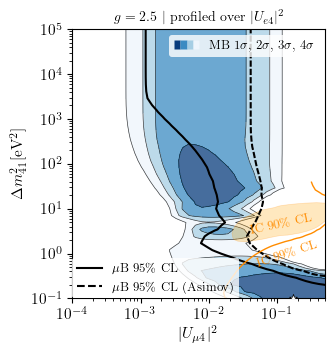

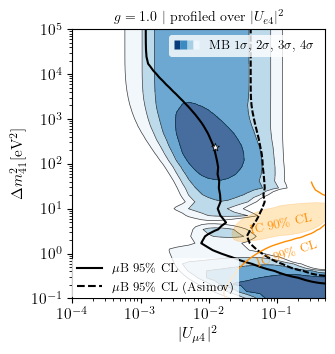

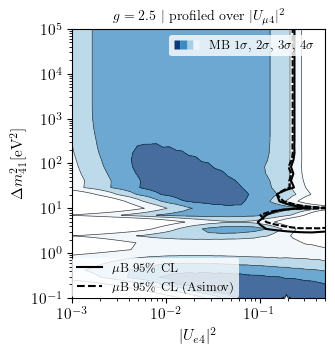

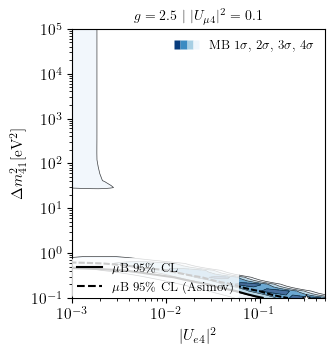

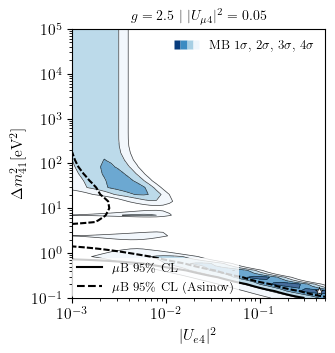

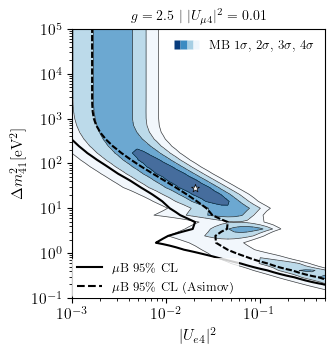

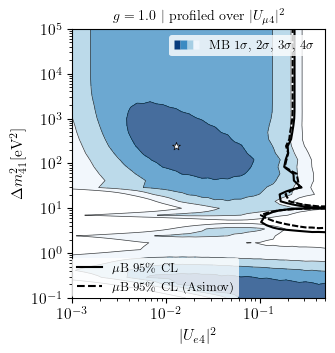

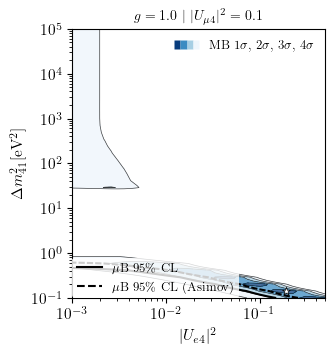

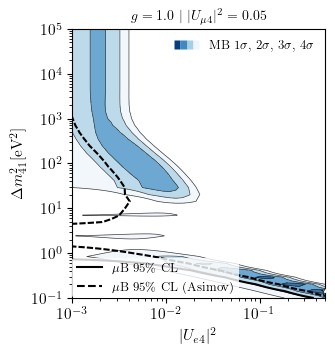

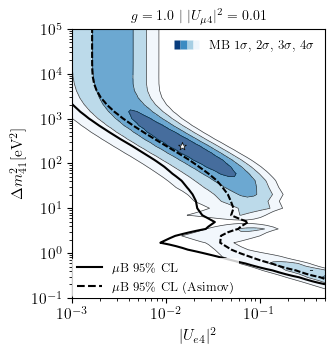

In [161]:
color = 'Blues_r'
make_mass_vs_mixing_plot(data_full_gfixed_2p5_Umu4prof, mixing='Umu4SQR', name=r'$g = 2.5$ $\vert$ profiled over $|U_{e4}|^2$', suffix='gfixed_2p5', plot_IC=True, n_sigmas=4, cmap_color=color)
make_mass_vs_mixing_plot(data_full_gfixed_1p0_Umu4prof, mixing='Umu4SQR', name=r'$g = 1.0$ $\vert$ profiled over $|U_{e4}|^2$', suffix='gfixed_1p0', plot_IC=True, n_sigmas=4, cmap_color=color)
# make_mass_vs_mixing_plot(data_full_gfixed_2p5_best, mixing='Umu4SQR', name=r'$g = 2.5$ $\vert$ $|U_{e 4}|^2 = 0.1$', suffix='gfixed_2p5_best', plot_IC=True, n_sigmas=4, cmap_color=color)
# make_mass_vs_mixing_plot(data_full_gfixed_2p5_solar, mixing='Umu4SQR', name=r'$g = 2.5$ $\vert$ $|U_{e 4}|^2 = 0.05$', suffix='gfixed_2p5_solar', plot_IC=True, n_sigmas=4, cmap_color=color, plot_Asimov=False)
# make_mass_vs_mixing_plot(data_full_gfixed_2p5_001, mixing='Umu4SQR', name=r'$g = 2.5$ $\vert$ $|U_{e 4}|^2 = 0.01$', suffix='gfixed_2p5_small', plot_IC=True, n_sigmas=4, cmap_color=color)


make_mass_vs_mixing_plot(data_full_gfixed_2p5_Ue4prof, mixing='Ue4SQR' ,name=r'$g = 2.5$ $\vert$ profiled over $|U_{\mu 4}|^2$', suffix='gfixed_2p5', plot_IC=False, n_sigmas=4, cmap_color=color)
make_mass_vs_mixing_plot(data_full_gfixed_2p5_best_Ue4prof, mixing='Ue4SQR' ,name=r'$g = 2.5$ $\vert$ $|U_{\mu 4}|^2 = 0.1$', suffix='gfixed_2p5_best', plot_IC=False, n_sigmas=4, cmap_color=color)
make_mass_vs_mixing_plot(data_full_gfixed_2p5_solar_Ue4prof, mixing='Ue4SQR' ,name=r'$g = 2.5$ $\vert$ $|U_{\mu 4}|^2 = 0.05$', suffix='gfixed_2p5_solar', plot_IC=False, n_sigmas=4, cmap_color=color)
make_mass_vs_mixing_plot(data_full_gfixed_2p5_small_Ue4prof, mixing='Ue4SQR' ,name=r'$g = 2.5$ $\vert$ $|U_{\mu 4}|^2 = 0.01$', suffix='gfixed_2p5_small', plot_IC=False, n_sigmas=4, cmap_color=color)


make_mass_vs_mixing_plot(data_full_gfixed_1p0_Ue4prof, mixing='Ue4SQR' ,name=r'$g = 1.0$ $\vert$ profiled over $|U_{\mu 4}|^2$', suffix='gfixed_1p0', plot_IC=False, n_sigmas=4, cmap_color=color)
make_mass_vs_mixing_plot(data_full_gfixed_1p0_best_Ue4prof, mixing='Ue4SQR' ,name=r'$g = 1.0$ $\vert$ $|U_{\mu 4}|^2 = 0.1$', suffix='gfixed_1p0_best', plot_IC=False, n_sigmas=4, cmap_color=color)
make_mass_vs_mixing_plot(data_full_gfixed_1p0_solar_Ue4prof, mixing='Ue4SQR' ,name=r'$g = 1.0$ $\vert$ $|U_{\mu 4}|^2 = 0.05$', suffix='gfixed_1p0_solar', plot_IC=False, n_sigmas=4, cmap_color=color)
make_mass_vs_mixing_plot(data_full_gfixed_1p0_small_Ue4prof, mixing='Ue4SQR' ,name=r'$g = 1.0$ $\vert$ $|U_{\mu 4}|^2 = 0.01$', suffix='gfixed_1p0_small', plot_IC=False, n_sigmas=4, cmap_color=color)

In [243]:
# make_mixing_vs_mixing_plot(data_full_gfixed_2p5_dmfixed_500, name=r'$g_{\varphi} = 2.5$ $\vert$ $\Delta m_{41}^2 = 500$ eV$^2$', suffix='gfixed_2p5_dmfixed_500', plot_IC=True, n_sigmas=4, cmap_color=color)
# make_mixing_vs_mixing_plot(data_full_gfixed_2p5_dmfixed_500, name=r'$g_{\varphi} = 2.5$ $\vert$ $\Delta m_{41}^2 = 500$ eV$^2$', suffix='gfixed_2p5_dmfixed_500', plot_IC=True, n_sigmas=4, cmap_color=color)

# make_mixing_vs_mixing_plot(data_full_gfixed_1p0_dmfixed_100, name=r'$g_{\varphi} = 1.0$ $\vert$ $\Delta m_{41}^2 = 100$ eV$^2$', suffix='gfixed_1p0_dmfixed_100', plot_IC=True, n_sigmas=4, cmap_color=color)
# make_mixing_vs_mixing_plot(data_full_gfixed_1p0_dmfixed_100, name=r'$g_{\varphi} = 1.0$ $\vert$ $\Delta m_{41}^2 = 100$ eV$^2$', suffix='gfixed_1p0_dmfixed_100', plot_IC=True, n_sigmas=4, cmap_color=color)

In [162]:
labels_slices = [r'$g_\varphi$',r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', r"$|U_{e 4}|^2$", r"$|U_{\mu 4}|^2$", r"$\sin^2(2\theta_{\mu e})$"]
string_slices = [r'$g_\varphi$',r'$\Delta m_{41}^2$', r"$|U_{e 4}|^2$", r"$|U_{\mu 4}|^2$", r"$\sin^2(2\theta_{\mu e})$"]
def get_var(data, i):
    if i == 1:
        return data[:,1]**2
    return data[:,i]

def plot_all_slices(filename, xi=2, yi=3, zi=1, wi=0, w_fixed=1, global_deltachi2=False, n_sigmas=4, cmap_color='steelblue', cmin=0.05, cmax=0.95):
    data = param_scan.pickle_read(f"fit_data/{filename}.pkl")
    cut_in_w = data[np.argmin(np.abs(data[:,wi] == w_fixed)), wi]
    data = data[(data[:,wi] == cut_in_w)]
    
    MiniApp_chi2, MicroApp_chi2, MicroApp_Asimov_chi2 = data[:,-3], data[:,-2], data[:,-1] 
    
    x, y, z, w = get_var(data,xi), get_var(data,yi), get_var(data,zi), get_var(data,wi)
    i_min = np.argmin(MiniApp_chi2)
    x_min, y_min, z_min = x[i_min], y[i_min], z[i_min]
    
    z_slices = np.geomspace(np.min(z), np.max(z),9,endpoint=True)
    if z_min not in z_slices:
        z_slices = np.delete(z_slices, np.argmin(np.abs(z_slices - z_min)))
        z_slices = np.append(z_slices, z_min)
    z_slices = np.sort(z_slices)
    
    fig, axs = plt.subplots(3, 3, figsize=(8, 8), sharex=True, sharey=True, constrained_layout=True)
    # plt.subplots_adjust(hspace=0, wspace=0)
    axs = axs.flatten()
    for i, z_slice in enumerate(z_slices):
        z_slice_true = z[np.argmin(np.abs(z - z_slice))]
        cut = (z == z_slice_true)

        ax = axs[i]
        ax.set_xscale('log')
        ax.set_yscale('log')
        if i in [0,3,6]:
            ax.set_ylabel(string_slices[yi], fontproperties=pt.font)
        # else:
            # ax.set_yticklabels([])
            
        if i in [6,7,8]:
            ax.set_xlabel(string_slices[xi], fontproperties=pt.font)
        else:
            ax.set_xticklabels([])
        ax.annotate(text=fr"{string_slices[zi]} $\,= {z_slice_true:.3f}$", 
                    xycoords='axes fraction', 
                    xy=(0.05,0.9), 
                    fontsize=10, 
                    bbox=dict(facecolor='white', edgecolor='None', alpha=0.9, boxstyle='round'))

        le = len(np.unique(x))
        kwargs_interp = {'fine_gridx': le,  
                        'fine_gridy': le, 
                        'logx':True, 
                        'logy':True,
                        }

        if global_deltachi2:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MiniApp_chi2[cut]-np.min(MiniApp_chi2), **kwargs_interp)
        else:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MiniApp_chi2[cut]-np.min(MiniApp_chi2[cut]), **kwargs_interp)
        
        colors = pt.get_cmap_colors(cmap_color, n_sigmas, cmin=cmin, cmax=cmax)
        cs = ax.contourf(X,Y,Z, levels=pt.get_chi2vals_w_nsigmas(n_sigmas, 2), colors=['darkorange','orange','peachpuff'], zorder=1, alpha=0.75)
        cs = ax.contour(X,Y,Z, levels=pt.get_chi2vals_w_nsigmas(n_sigmas, 2), colors=['black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)

        if global_deltachi2:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_chi2[cut] - np.min(MicroApp_chi2), **kwargs_interp)
        else:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_chi2[cut] - np.min(MicroApp_chi2[cut]), **kwargs_interp)
        cs = ax.contour(X,Y,Z, levels=pt.get_chi2vals_w_CL(0.95, 2), colors=['black'], zorder=2)

        if global_deltachi2:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_Asimov_chi2[cut] - np.min(MicroApp_Asimov_chi2), **kwargs_interp)
        else:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_Asimov_chi2[cut] - np.min(MicroApp_Asimov_chi2[cut]), **kwargs_interp)
        cs = ax.contour(X,Y,Z, levels=pt.get_chi2vals_w_CL(0.95, 2), colors=['black'], linestyles=[(1,(3,1))], zorder=2)
        if z_min == z_slice:
            ax.scatter(x_min, y_min, marker='*', color='black',)
        ax.tick_params(axis="both", which='both', direction="inout", left="off", labelleft="on")
        ax.set_xlim(x.min(), x.max())
        ax.set_ylim(y.min(), y.max())
        if i == 0:
            h, l = ax.get_legend_handles_labels()
            h.append(pt.MulticolorPatch(colors))
            mb_label = 'MB '+', '.join([fr'${i+1} \sigma$' for i in range(n_sigmas)])
            l.append(mb_label)
            ax.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
            ax.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B 95\% CL (Asimov)')

            ax.legend(h, l, loc=(0,0), fontsize=9, handler_map={pt.MulticolorPatch: pt.MulticolorPatchHandler()})
    fig.suptitle(fr'{string_slices[wi]} $\,= {w_fixed:.2f}$')
    fig.savefig(f"{micro.path_plots}/{filename}_allslices_{xi}_{yi}_{zi}_{wi}_{w_fixed:.3f}{'_global' if global_deltachi2 else ''}.pdf", bbox_inches='tight', dpi=300)



### Ue4 vs dm4 (profile over Umu4)

In [163]:
labels_slices = [r'$g_\varphi$',r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', r"$|U_{e 4}|^2$", r"$|U_{\mu 4}|^2$", r"$\sin^2(2\theta_{\mu e})$"]
string_slices = [r'$g_\varphi$',r'$\Delta m_{41}^2$', r"$|U_{e 4}|^2$", r"$|U_{\mu 4}|^2$", r"$\sin^2(2\theta_{\mu e})$"]
def get_var(data, i):
    if i == 1:
        return data[:,1]**2
    return data[:,i]

def plot_all_slices(filename, xi=2, yi=3, zi=1, z_range=None, wi=0, w_fixed=1, global_deltachi2=False, n_sigmas=4, plot_Asimov=True, cmap_color='steelblue', microColor='black', microColor_2='grey', cmin=0.05, cmax=0.9):
    data = param_scan.pickle_read(f"fit_data/{filename}.pkl")
    cut_in_w = data[np.argmin(np.abs(data[:,wi] - w_fixed)), wi]
    data = data[(data[:,wi] == cut_in_w)]

    MiniApp_chi2, MicroApp_chi2, MicroApp_Asimov_chi2 = data[:,-3], data[:,-2], data[:,-1] 
    
    x, y, z, w = get_var(data,xi), get_var(data,yi), get_var(data,zi), get_var(data, wi)
    i_min = np.argmin(MiniApp_chi2)
    x_min, y_min, z_min = x[i_min], y[i_min], z[i_min]
    if z_range is not None:
        z_slices = np.geomspace(z_range[0], z_range[1], 9,endpoint=True)
    else:
        z_slices = np.geomspace(np.min(z), np.max(z),9,endpoint=True)

    if z_min not in z_slices:
        z_slices = np.delete(z_slices, np.argmin(np.abs(z_slices - z_min)))
        z_slices = np.append(z_slices, z_min)
    z_slices = np.sort(z_slices)
    
    fig, axs = plt.subplots(3, 3, figsize=(10, 8), sharex=False, sharey=False, constrained_layout=False)
    plt.subplots_adjust(hspace=0.075, wspace=0.05)
    axs = axs.flatten()
    for i, z_slice in enumerate(z_slices):
        z_slice_true = z[np.argmin(np.abs(z - z_slice))]
        cut = (z == z_slice_true)

        ax = axs[i]
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.tick_params(axis="both", which='both', direction="inout", left="off", labelleft="on", zorder=10)
        # ax.set_xticklabels(fontsize=13)
        # ax.set_yticklabels(fontsize=13)

        ax.set_xlim(x.min(), x.max())
        ax.set_ylim(y.min(), y.max())

        if i in [0,3,6]:
            ylabel = string_slices[yi]
            if yi == 1:
                ylabel += r"/eV$^2$"

            ax.set_ylabel(ylabel, fontproperties=pt.font, fontsize=11)
        else:
            ax.set_yticklabels([])
            
        if i in [6,7,8]:
            ax.set_xlabel(string_slices[xi], fontproperties=pt.font, fontsize=11)
        else:
            ax.set_xticklabels([])

        fixed_value = fr"{string_slices[zi]} \,$= {pt.sci_notation(z_slice_true, sig_digits=1, notex=True, optional_sci=2)}$"
        if zi == 1:
            fixed_value += r"\, eV$^2$"
        ax.annotate(text=fixed_value, 
                    xycoords='axes fraction', 
                    xy=(0.05,0.86), 
                    fontsize=11, 
                    bbox=dict(facecolor='white', edgecolor='None', alpha=0.9, boxstyle='round'))

        kwargs_interp = {   'fine_gridx': len(np.unique(x)),  
                            'fine_gridy': len(np.unique(y)), 
                            'logx':True, 
                            'logy':True,
                        }

        if global_deltachi2:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MiniApp_chi2[cut]-np.min(MiniApp_chi2), **kwargs_interp)
            ndof = 3
        else:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MiniApp_chi2[cut]-np.min(MiniApp_chi2[cut]), **kwargs_interp)
            ndof = 2
        
        colors = pt.get_cmap_colors(cmap_color, n_sigmas, cmin=cmin, cmax=cmax)
        cs = ax.contourf(X,Y,Z, levels=pt.get_chi2vals_w_nsigmas(n_sigmas, ndof), colors=colors, zorder=1, alpha=1)
        cs = ax.contour(X,Y,Z, levels=pt.get_chi2vals_w_nsigmas(n_sigmas, ndof), colors=['black','black','black'], linewidths=0.25, zorder=1, alpha=1)
        ax.scatter(X.flatten()[np.nanargmin(Z)], Y.flatten()[np.nanargmin(Z)], marker='*', facecolor='white', edgecolor='black', lw=0.5, zorder=10)
        # print('Minimum: ', X.flatten()[np.nanargmin(Z)], Y.flatten()[np.nanargmin(Z)], np.min(Z))

        if global_deltachi2:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_chi2[cut] - np.min(MicroApp_chi2), **kwargs_interp)
        else:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_chi2[cut] - np.min(MicroApp_chi2[cut]), **kwargs_interp)
        cs = ax.contour(X,Y,Z, levels=pt.get_chi2vals_w_CL([0.95], ndof), colors=[microColor], zorder=2)
        cs = ax.contour(X,Y,Z, levels=pt.get_chi2vals_w_CL([0.99], ndof), colors=[microColor], linestyles=[(1,(3,0.5))], zorder=2)

        if global_deltachi2:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_Asimov_chi2[cut] - np.min(MicroApp_Asimov_chi2), **kwargs_interp)
        else:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_Asimov_chi2[cut] - np.min(MicroApp_Asimov_chi2[cut]), **kwargs_interp)
        if plot_Asimov:
            cs = ax.contour(X,Y,Z, levels=pt.get_chi2vals_w_CL([0.99], ndof), colors=[microColor_2], linestyles=[(1,(3,0.5))], linewidths=1, zorder=2)
        if z_min == z_slice:
            ax.scatter(x_min, y_min, marker='*', facecolor='black', edgecolor='black', lw=0.25, zorder=10)
        if i == 0:
            ax.plot([], [], color='grey', lw=1.5, ls=(1,(3,0.5)), label='$\mu$B 99\% CL (Asimov)')
            ax.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
            ax.plot([], [], color='black', lw=1.5, ls=(1,(3,0.5)), label='$\mu$B 99\% CL')
            h, l = ax.get_legend_handles_labels()
            h.append(pt.MulticolorPatch(colors))
            mb_label = 'MB '+', '.join([fr'${i+1} \sigma$' for i in range(n_sigmas)])
            l.append(mb_label)
            ax.legend(h, l, loc=(0,0), fontsize=9, handler_map={pt.MulticolorPatch: pt.MulticolorPatchHandler()})
    nstring = r'n_{\rm dof}'
    ndof = rf' $\vert$ ${nstring} = {ndof}$'
    axs[1].annotate(text=fr"{string_slices[wi]} $\,= {w_fixed:.2f}${ndof}", xycoords='axes fraction', xy=(0.5,1.075), fontsize=10, ha='center', zorder=10)
    fig.savefig(f"{micro.path_plots}/MH_decay_allslices_{xi}_{yi}_{zi}_{wi}_{w_fixed:.3f}{'_global' if global_deltachi2 else ''}.pdf", bbox_inches='tight', dpi=350)



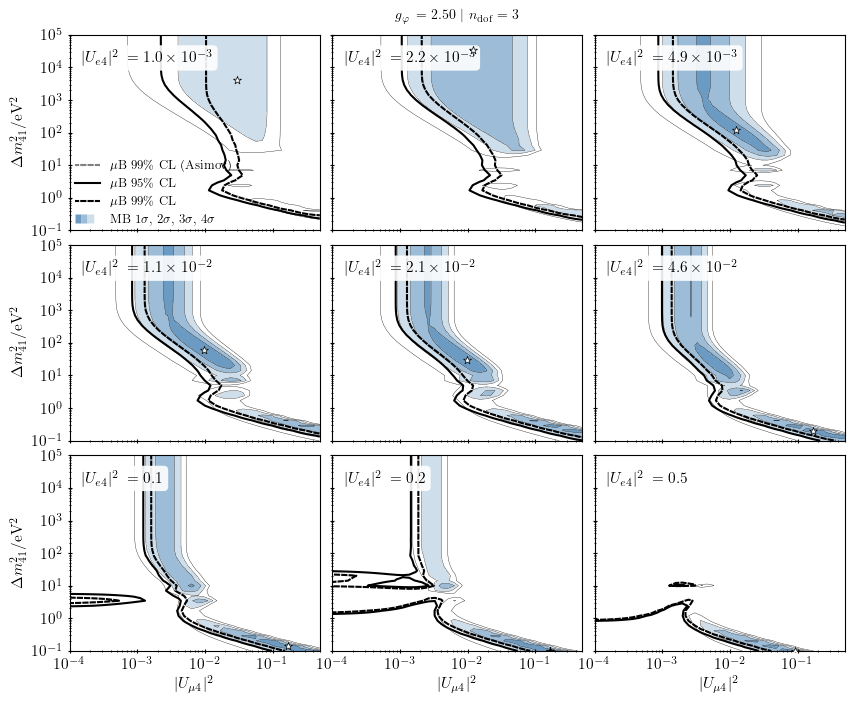

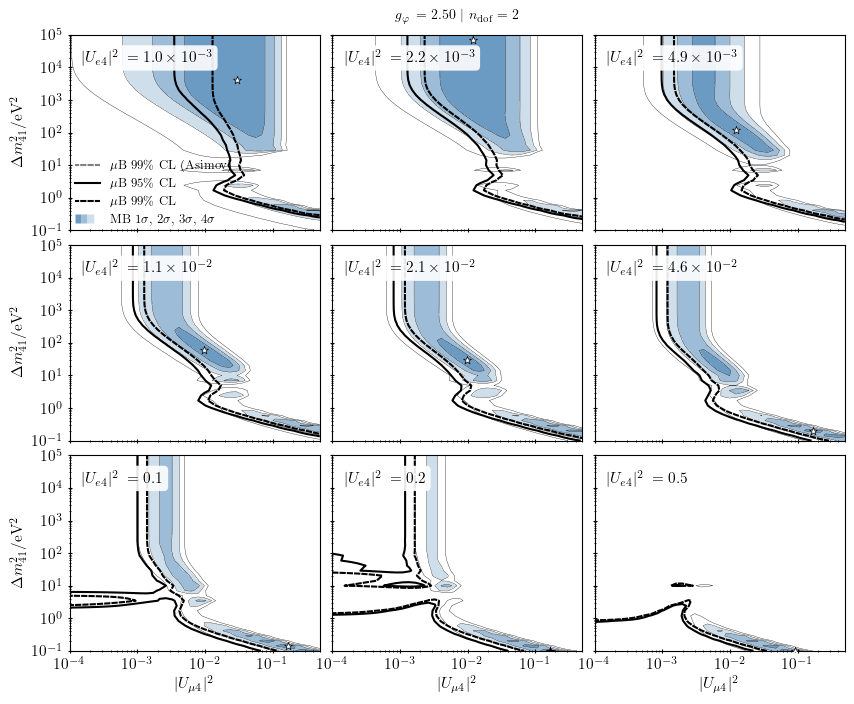

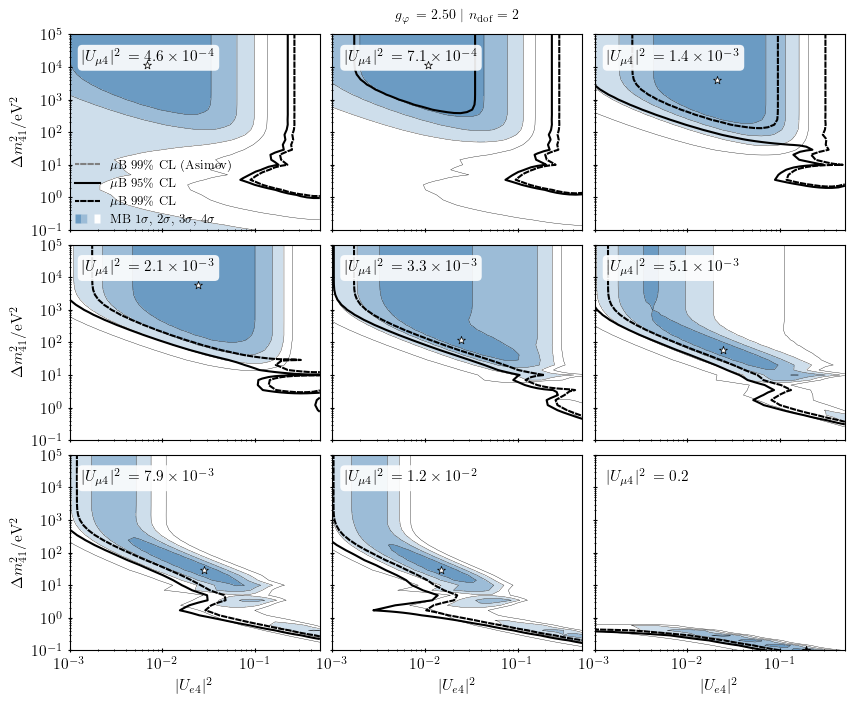

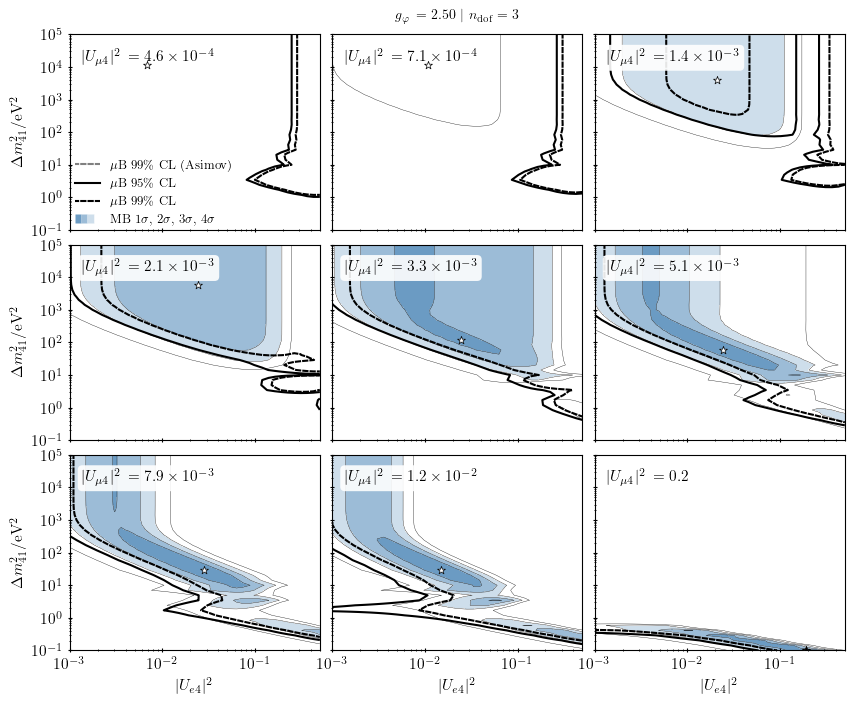

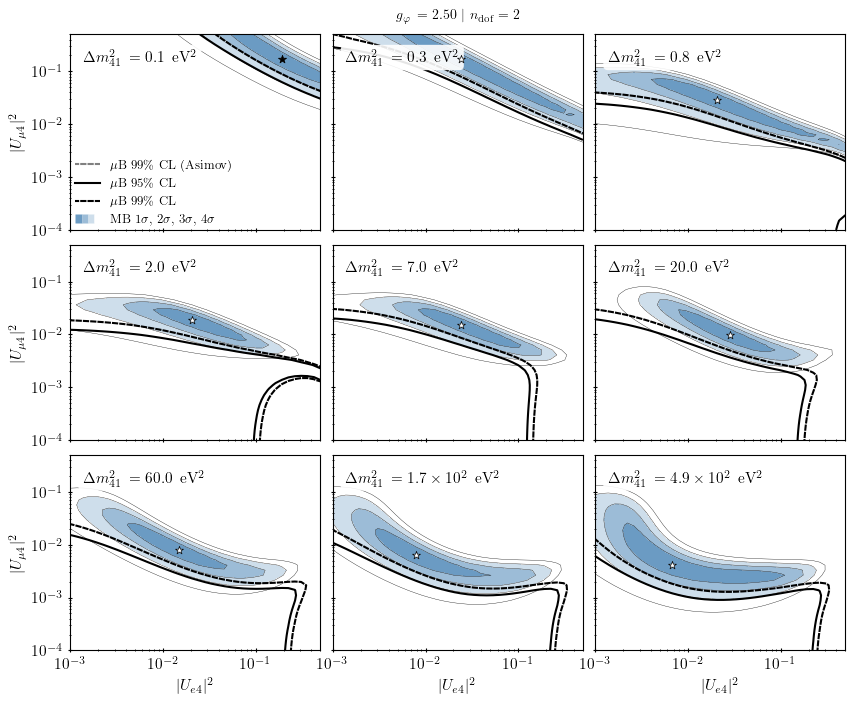

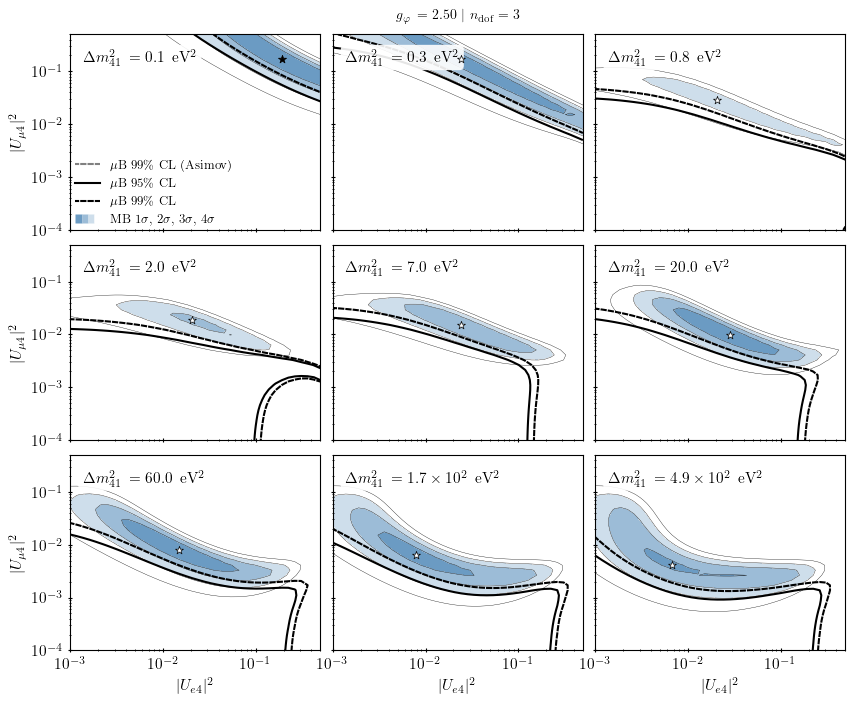

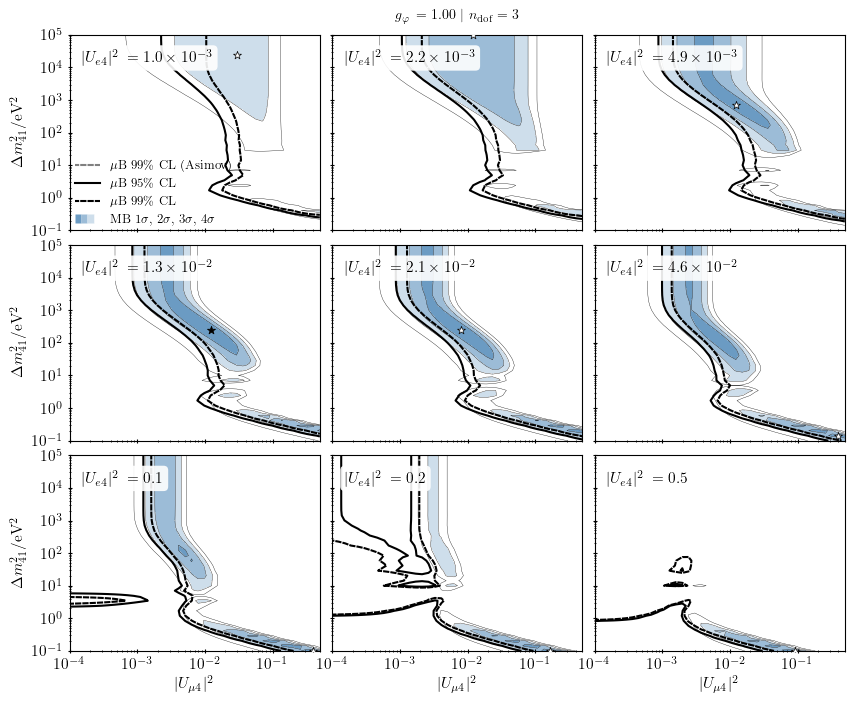

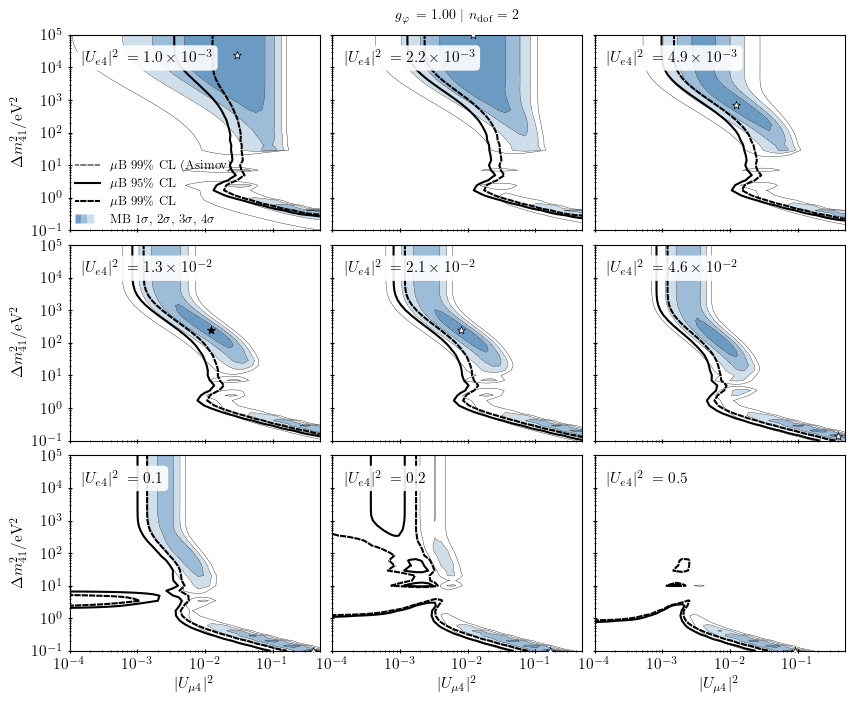

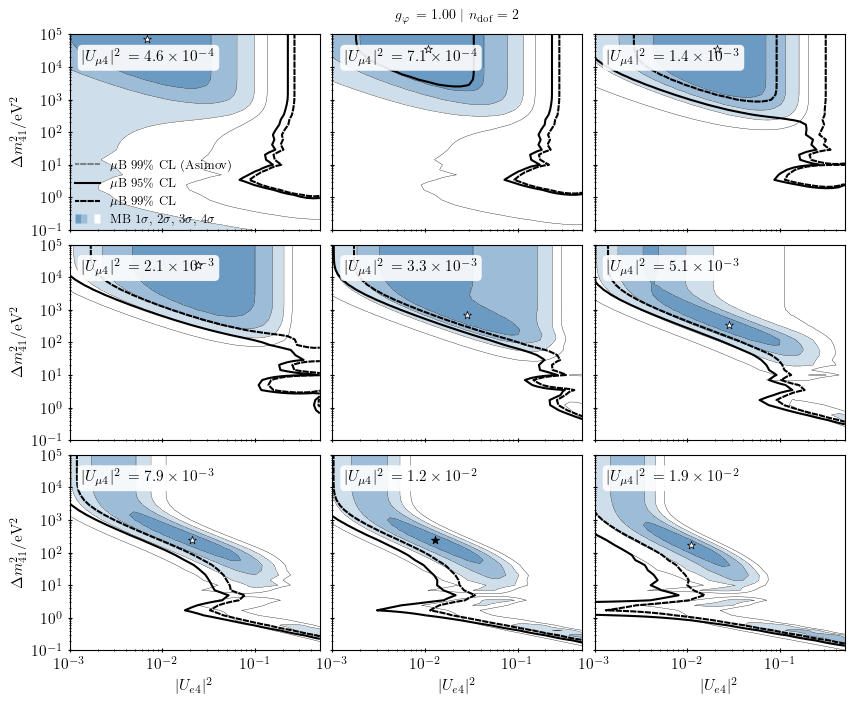

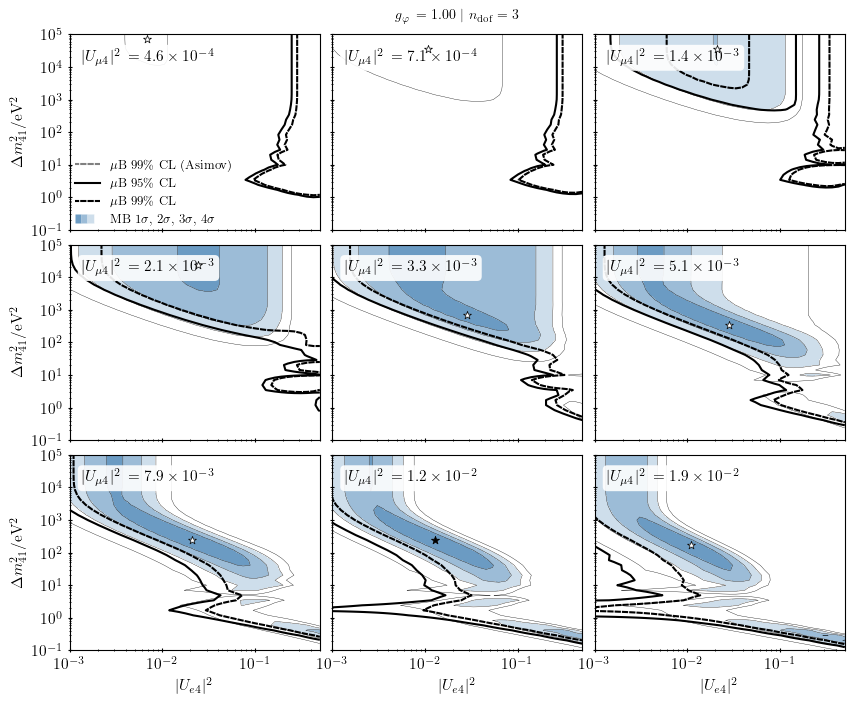

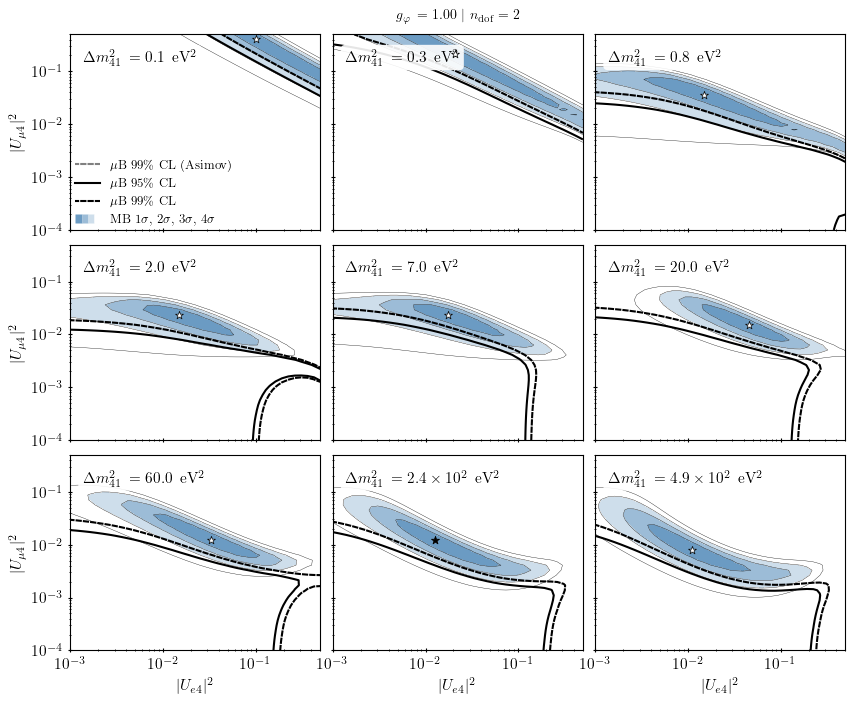

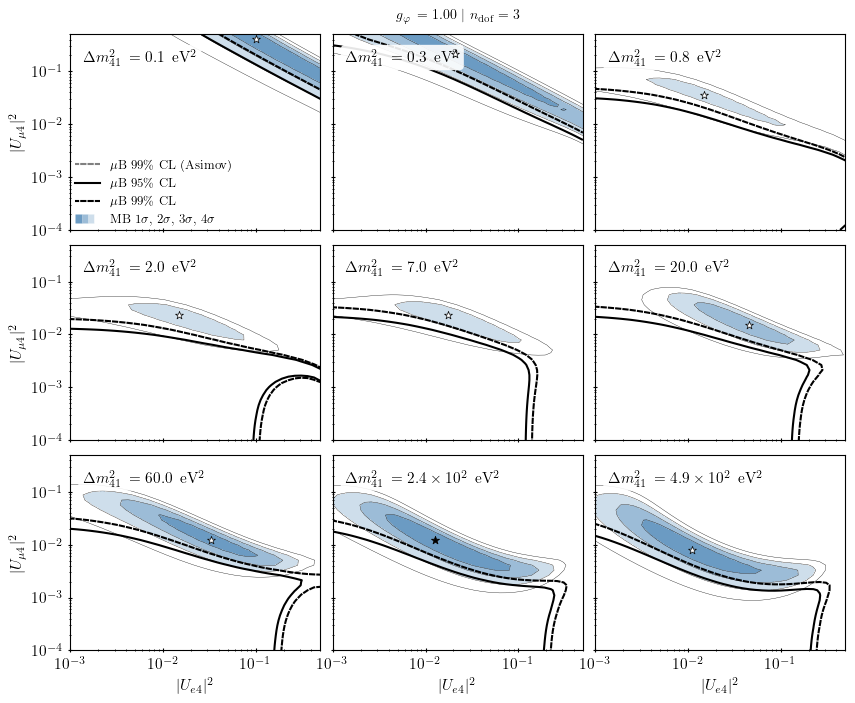

In [164]:
CMAP = 'steelblue'
microColor='black'
microColor_2 = 'darkorange'
kwargs = {'plot_Asimov': False, 'microColor': microColor, 'microColor_2': microColor_2, 'cmap_color': CMAP, 'n_sigmas': 4, 'cmin': 0.2, 'cmax': 1}

plot_all_slices('MH_decay_gfixed_2.5_3D_40', xi=3, yi=1, zi=2, z_range=[1e-3, 0.5], wi=0, w_fixed=2.5, global_deltachi2=True, **kwargs)
plot_all_slices('MH_decay_gfixed_2.5_3D_40', xi=3, yi=1, zi=2, z_range=[1e-3, 0.5], wi=0, w_fixed=2.5, global_deltachi2=False, **kwargs)

plot_all_slices('MH_decay_gfixed_2.5_3D_40', xi=2, yi=1, zi=3, z_range=[5e-4, 0.02], wi=0, w_fixed=2.5, global_deltachi2=False, **kwargs)
plot_all_slices('MH_decay_gfixed_2.5_3D_40', xi=2, yi=1, zi=3, z_range=[5e-4, 0.02], wi=0, w_fixed=2.5, global_deltachi2=True, **kwargs)

plot_all_slices('MH_decay_gfixed_2.5_3D_40', xi=2, yi=3, zi=1, z_range=[0.1, 500], wi=0, w_fixed=2.5, global_deltachi2=False, **kwargs)
plot_all_slices('MH_decay_gfixed_2.5_3D_40', xi=2, yi=3, zi=1, z_range=[0.1, 500], wi=0, w_fixed=2.5, global_deltachi2=True, **kwargs)


plot_all_slices('MH_decay_gfixed_1.0_3D_40', xi=3, yi=1, zi=2, z_range=[1e-3, 0.5], wi=0, w_fixed=1.0, global_deltachi2=True, **kwargs)
plot_all_slices('MH_decay_gfixed_1.0_3D_40', xi=3, yi=1, zi=2, z_range=[1e-3, 0.5], wi=0, w_fixed=1.0, global_deltachi2=False, **kwargs)

plot_all_slices('MH_decay_gfixed_1.0_3D_40', xi=2, yi=1, zi=3, z_range=[5e-4, 0.02], wi=0, w_fixed=1.0, global_deltachi2=False, **kwargs)
plot_all_slices('MH_decay_gfixed_1.0_3D_40', xi=2, yi=1, zi=3, z_range=[5e-4, 0.02], wi=0, w_fixed=1.0, global_deltachi2=True, **kwargs)

plot_all_slices('MH_decay_gfixed_1.0_3D_40', xi=2, yi=3, zi=1, z_range=[0.1, 500], wi=0, w_fixed=1.0, global_deltachi2=False, **kwargs)
plot_all_slices('MH_decay_gfixed_1.0_3D_40', xi=2, yi=3, zi=1, z_range=[0.1, 500], wi=0, w_fixed=1.0, global_deltachi2=True, **kwargs)


In [57]:
# color='Blues_r'
# plot_all_slices('MH_decay_test_30', xi=2, yi=3, zi=1, z_range=[0.1, 500], wi=0, w_fixed=2.8, global_deltachi2=False, cmap_color=color)
# plot_all_slices('MH_decay_test_30', xi=2, yi=3, zi=1, z_range=[0.1, 500], wi=0, w_fixed=2.8, global_deltachi2=True, cmap_color=color)

# plot_all_slices('MH_decay_test_30', xi=2, yi=3, zi=1, z_range=[0.1, 500], wi=0, w_fixed=1, global_deltachi2=False, cmap_color=color)
# plot_all_slices('MH_decay_test_30', xi=2, yi=3, zi=1, z_range=[0.1, 500], wi=0, w_fixed=1, global_deltachi2=True, cmap_color=color)


In [56]:
# color = 'Blues_r'
# plot_all_slices('MH_decay_test_30', xi=3, yi=1, zi=0, wi=2, w_fixed=0.2, global_deltachi2=False, cmap_color=color)
# plot_all_slices('MH_decay_test_30', xi=3, yi=1, zi=0, wi=2, w_fixed=0.1, global_deltachi2=False, cmap_color=color)
# plot_all_slices('MH_decay_test_30', xi=3, yi=1, zi=0, wi=2, w_fixed=0.05, global_deltachi2=False, cmap_color=color)

# plot_all_slices('MH_decay_test_30', xi=2, yi=1, zi=0, wi=3, w_fixed=0.1, global_deltachi2=False, cmap_color=color)
# plot_all_slices('MH_decay_test_30', xi=2, yi=1, zi=0, wi=3, w_fixed=0.05, global_deltachi2=False, cmap_color=color)
# plot_all_slices('MH_decay_test_30', xi=2, yi=1, zi=0, wi=3, w_fixed=0.01, global_deltachi2=False, cmap_color=color)


# plot_all_slices('MH_decay_test_30', xi=3, yi=1, zi=0, wi=2, w_fixed=0.1, global_deltachi2=True, cmap_color=color)
# plot_all_slices('MH_decay_test_30', xi=3, yi=1, zi=0, wi=2, w_fixed=0.05, global_deltachi2=True, cmap_color=color)
# plot_all_slices('MH_decay_test_30', xi=2, yi=1, zi=0, wi=3, w_fixed=0.05, global_deltachi2=True, cmap_color=color)
# plot_all_slices('MH_decay_test_30', xi=2, yi=1, zi=0, wi=3, w_fixed=0.01, global_deltachi2=True, cmap_color=color)

### GIFs

In [179]:
import matplotlib.animation
from matplotlib.animation import FuncAnimation

# Your existing function with a few modifications
def make_gif(filename, xi=2, yi=3, zi=1, z_range=None, wi=0, w_fixed=1, frames = 10, global_deltachi2=False, osc=False, plot_Asimov=True, microColor='darkorange', microColor_2='grey', cmap_color='steelblue', n_sigmas=4, cmin=0.05, cmax=0.95):
    data = param_scan.pickle_read(f"fit_data/{filename}.pkl")
    cut_in_w = data[np.argmin(np.abs(data[:,wi] - w_fixed)), wi]
    data = data[(data[:,wi] == cut_in_w)]

    MiniApp_chi2, MicroApp_chi2, MicroApp_Asimov_chi2 = data[:,-3], data[:,-2], data[:,-1] 
    
    x, y, z, w = get_var(data,xi), get_var(data,yi), get_var(data,zi), get_var(data, wi)
    i_min = np.argmin(MiniApp_chi2)
    x_min, y_min, z_min = x[i_min], y[i_min], z[i_min]
    if len(np.unique(z) < frames):
        print("Adjusting number of frames to match number of unique z values")
        frames = len(np.unique(z))
    if z_range is not None:
        z_slices = np.geomspace(z_range[0], z_range[1], frames,endpoint=True)
    else:
        z_slices = np.geomspace(np.min(z), np.max(z), frames, endpoint=True)

    if z_min not in z_slices:
        z_slices = np.delete(z_slices, np.argmin(np.abs(z_slices - z_min)))
        z_slices = np.append(z_slices, z_min)
    z_slices = np.sort(z_slices)
    
    fig, ax = pt.std_fig(figsize=(4, 4), ax_form=pt.std_axes_form)
    # Create a function to update the plot for each frame
    def update(frame):
        ax.clear()
        z_slice = z_slices[frame]
        z_slice_true = z[np.argmin(np.abs(z - z_slice))]
        cut = (z == z_slice_true)
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.tick_params(axis="both", which='both', direction="inout", left="off", labelleft="on", zorder=10)

        ax.set_xlim(x.min(), x.max())
        ax.set_ylim(y.min(), y.max())
        ax.set_ylabel(string_slices[yi], fontproperties=pt.font, fontsize=10)    
        ax.set_xlabel(string_slices[xi], fontproperties=pt.font, fontsize=10)

        fixed_value = fr"{string_slices[zi]} \,$= {pt.sci_notation(z_slice_true, sig_digits=1, notex=True, optional_sci=3)}$"
        if zi == 1:
            fixed_value += r"\, eV$^2$"

        kwargs_interp = {   'fine_gridx': len(np.unique(x)),  
                            'fine_gridy': len(np.unique(y)), 
                            'logx':True, 
                            'logy':True,
                        }

        if global_deltachi2:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MiniApp_chi2[cut]-np.min(MiniApp_chi2), **kwargs_interp)
            ndof = 3
        else:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MiniApp_chi2[cut]-np.min(MiniApp_chi2[cut]), **kwargs_interp)
            ndof = 2
        
        colors = pt.get_cmap_colors(cmap_color, n_sigmas, cmin=cmin, cmax=cmax)
        cs = ax.contourf(X,Y,Z, levels=pt.get_chi2vals_w_nsigmas(n_sigmas, ndof), colors=colors, zorder=1, alpha=1)
        cs = ax.contour(X,Y,Z, levels=pt.get_chi2vals_w_nsigmas(n_sigmas, ndof), colors=['black','black','black'], linewidths=0.5, zorder=1, alpha=1)
        ax.scatter(X.flatten()[np.nanargmin(Z)], Y.flatten()[np.nanargmin(Z)], marker='*', facecolor='white', edgecolor='black', lw=0.5, zorder=10)

        if global_deltachi2:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_chi2[cut] - np.min(MicroApp_chi2), **kwargs_interp)
        else:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_chi2[cut] - np.min(MicroApp_chi2[cut]), **kwargs_interp)

        if global_deltachi2:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_Asimov_chi2[cut] - np.min(MicroApp_Asimov_chi2), **kwargs_interp)
        else:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_Asimov_chi2[cut] - np.min(MicroApp_Asimov_chi2[cut]), **kwargs_interp)

        # cs = ax.contour(X,Y,Z, levels=pt.get_chi2vals_w_CL([0.95], ndof), colors=['black'], linestyles=[(1,(3,1))], zorder=2)
        cs = ax.contour(X,Y,Z, levels=[pt.get_chi2vals_w_sigma(2,2),pt.get_chi2vals_w_sigma(3,2)], colors=[microColor,microColor], zorder=2, linewidths=1.5, linestyles=['-', (1,(3,0.5))])

        if z_min == z_slice:
            ax.scatter(x_min, y_min, marker='*', facecolor='black', edgecolor='black', lw=0.25, zorder=10)

        ax.plot([], [], color=microColor, lw=1.5, label='$\mu$B 2$\sigma$')
        ax.plot([], [], color=microColor, lw=1.5, ls=(1,(3,0.5)), label='$\mu$B 3$\sigma$')
        h, l = ax.get_legend_handles_labels()
        h.append(pt.MulticolorPatch(colors))
        mb_label = 'MB '+', '.join([fr'${i+1} \sigma$' for i in range(n_sigmas)])
        l.append(mb_label)
        ax.legend(h, l, loc=(0,0), fontsize=9, handler_map={pt.MulticolorPatch: pt.MulticolorPatchHandler()})

        nstring = r'n_{\rm dof}'
        if osc:
            ndof = rf'${nstring} = {ndof}$'
            ax.annotate(text=fr"{ndof} $\vert$ {fixed_value}", xycoords='axes fraction', xy=(0.5,1.025), fontsize=10, ha='center', zorder=10)
        else:
            ndof = rf' $\vert$ ${nstring} = {ndof}$'
            ax.annotate(text=fr"{string_slices[wi]} $\,= {w_fixed:.2f}${ndof} $\vert$ {fixed_value}", xycoords='axes fraction', xy=(0.5,1.025), fontsize=10, ha='center', zorder=10)

        # Return a tuple of the artists that have been updated. This tells the animation framework what parts of the plot should be animated.
        return (cs,)

    # Create the animation object. This will animate the 'update' function across the frames of your z_slices.
    anim = FuncAnimation(fig, update, frames=len(z_slices), blit=True)

    # Save the animation to a file
    anim.save(f"{micro.path_plots}/MH_gif_{xi}_{yi}_{zi}_{wi}_{w_fixed:.3f}{'_global' if global_deltachi2 else ''}.gif", writer='Pillow', fps=5, dpi=300)  

MovieWriter Pillow unavailable; using Pillow instead.


Adjusting number of frames to match number of unique z values
Adjusting number of frames to match number of unique z values


MovieWriter Pillow unavailable; using Pillow instead.


Adjusting number of frames to match number of unique z values


MovieWriter Pillow unavailable; using Pillow instead.


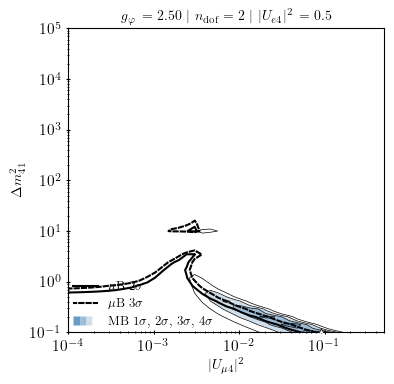

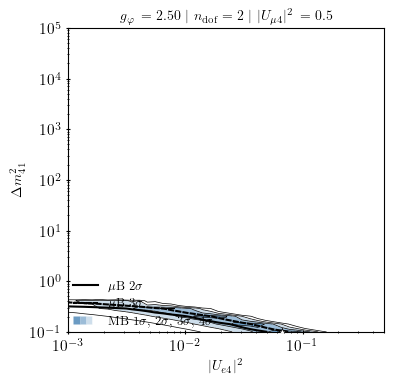

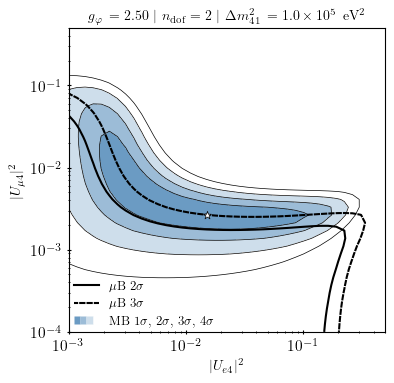

In [182]:
CMAP = 'steelblue'
microColor='black'
microColor_2 = 'darkorange'
kwargs = {'plot_Asimov': False, 'microColor': microColor, 'microColor_2': microColor_2, 'cmap_color': CMAP, 'n_sigmas': 4, 'cmin': 0.2, 'cmax': 1}

# make_gif('MH_decay_gfixed_2.5_3D_40', xi=3, yi=1, zi=2, wi=0, w_fixed=2.5, global_deltachi2=True, frames=60, **kwargs)
# make_gif('MH_decay_gfixed_2.5_3D_40', xi=2, yi=1, zi=3, wi=0, w_fixed=2.5, global_deltachi2=True, frames=60, **kwargs)
# make_gif('MH_decay_gfixed_2.5_3D_40', xi=2, yi=3, zi=1, wi=0, w_fixed=2.5, global_deltachi2=True, frames=60, **kwargs)


make_gif('MH_decay_gfixed_2.5_3D_40', xi=3, yi=1, zi=2, wi=0, w_fixed=2.5, global_deltachi2=False, frames=60, **kwargs)
make_gif('MH_decay_gfixed_2.5_3D_40', xi=2, yi=1, zi=3, wi=0, w_fixed=2.5, global_deltachi2=False, frames=60, **kwargs)
make_gif('MH_decay_gfixed_2.5_3D_40', xi=2, yi=3, zi=1, wi=0, w_fixed=2.5, global_deltachi2=False, frames=60, **kwargs)



MovieWriter Pillow unavailable; using Pillow instead.


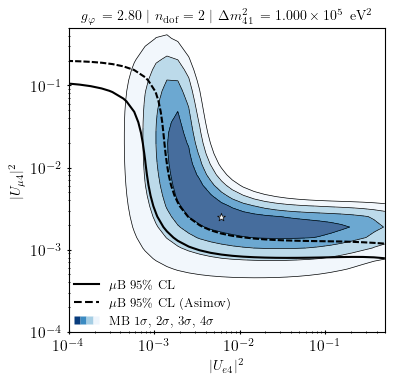

In [343]:
make_gif('MH_decay_gfixed_1.0_3D_40', xi=3, yi=1, zi=2, wi=0, w_fixed=1.0, global_deltachi2=False, frames=60, **kwargs)
make_gif('MH_decay_gfixed_1.0_3D_40', xi=2, yi=1, zi=3, wi=0, w_fixed=1.0, global_deltachi2=False, frames=60, **kwargs)
make_gif('MH_decay_gfixed_1.0_3D_40', xi=2, yi=3, zi=1, wi=0, w_fixed=1.0, global_deltachi2=False, frames=60, **kwargs)

make_gif('MH_decay_gfixed_1.0_3D_40', xi=3, yi=1, zi=2, wi=0, w_fixed=1.0, global_deltachi2=True, frames=60, **kwargs)
make_gif('MH_decay_gfixed_1.0_3D_40', xi=2, yi=1, zi=3, wi=0, w_fixed=1.0, global_deltachi2=True, frames=60, **kwargs)
make_gif('MH_decay_gfixed_1.0_3D_40', xi=2, yi=3, zi=1, wi=0, w_fixed=1.0, global_deltachi2=True, frames=60, **kwargs)

In [ ]:
make_gif('MH_decay_4D_30', xi=2, yi=3, zi=0, wi=1, w_fixed=1e4, global_deltachi2=True, frames=60, **kwargs)
make_gif('MH_decay_4D_30', xi=2, yi=3, zi=0, wi=1, w_fixed=1e4, global_deltachi2=True, frames=60, **kwargs)

MovieWriter Pillow unavailable; using Pillow instead.


Adjusting number of frames to match number of unique z values


MovieWriter Pillow unavailable; using Pillow instead.


Adjusting number of frames to match number of unique z values


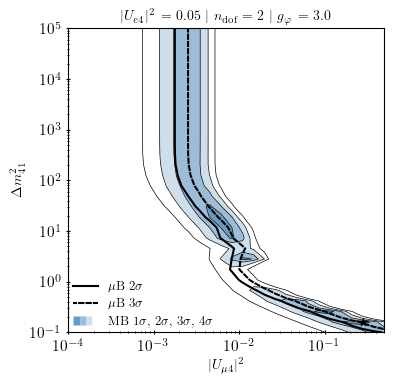

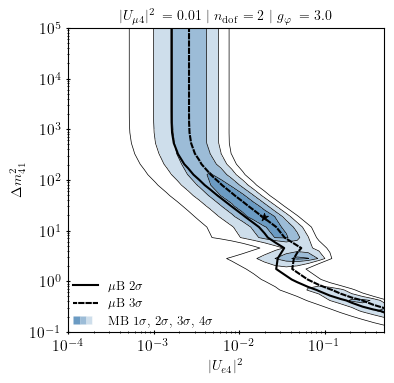

In [186]:
# make_gif('MH_decay_4D_30', xi=3, yi=1, zi=0, wi=2, w_fixed=0.05, global_deltachi2=False, frames=60, **kwargs)
# make_gif('MH_decay_4D_30', xi=2, yi=1, zi=0, wi=3, w_fixed=0.01, global_deltachi2=False, frames=60, **kwargs)


make_gif('MH_decay_4D_30', xi=3, yi=1, zi=0, wi=2, w_fixed=0.05, global_deltachi2=True, frames=60, **kwargs)
make_gif('MH_decay_4D_30', xi=2, yi=1, zi=0, wi=3, w_fixed=0.01, global_deltachi2=True, frames=60, **kwargs)

MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.


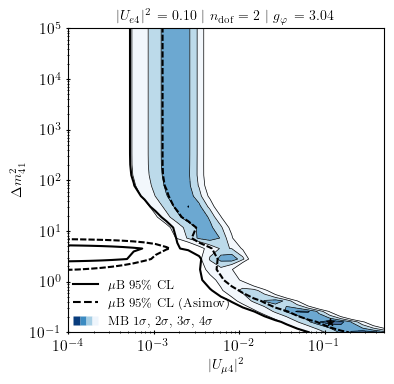

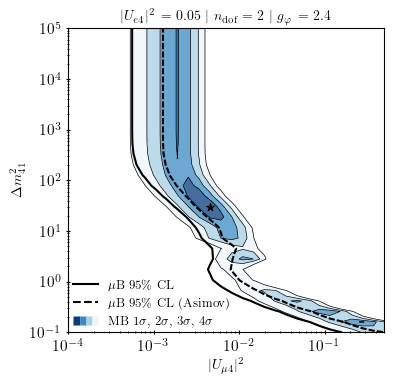

In [344]:
cmap_color = 'Blues_r'
make_gif('MH_decay_test_30', xi=3, yi=1, zi=0, wi=2, w_fixed=0.1, global_deltachi2=False, cmap_color=color)
make_gif('MH_decay_test_30', xi=3, yi=1, zi=0, wi=2, w_fixed=0.05, global_deltachi2=False, cmap_color=color)